# Trabalho Final

## Utilizando agrupamento nebuloso para analisar relação das vulnerabilidades demográficas e socioeconômicas dos municípios brasileiros com os efeitos da Covid-19

### Preparação dos dados 

In [382]:
import datetime
import pandas as pd
from scipy.stats import stats
from sklearn import preprocessing
import skfuzzy.cluster as cluster
import numpy as np
import matplotlib.pyplot as plt
import os
import unidecode


#### Dados epidemiológicos - consolidado

In [366]:
directory_covid = os.fsencode('dados/covid')
df_covid = None
for file in os.listdir(directory_covid):
    filename = 'dados/covid/' + os.fsdecode(file)
    df_temp = pd.read_csv(filename, decimal=',', sep=';')
    if df_covid is None:
        df_covid = df_temp
    else:
        df_covid = pd.concat([df_covid, df_temp])

df_covid = df_covid[df_covid.municipio.isnull() == False]
df_covid.data = pd.to_datetime(df_covid.data, infer_datetime_format=True)

df_covid = df_covid.rename(
    columns={'regiao': 'REGIAO', 'estado': 'SIGLA_ESTADO', 'municipio': 'MUNICIPIO', 'coduf': 'CODIGO_ESTADO',
             'codmun': 'CODIGO_MUNICIPIO_6', 'codRegiaoSaude': 'CODIGO_REGIAO_SAUDE', 'nomeRegiaoSaude': 'REGIAO_SAUDE',
             'casosAcumulado': 'CASOS', 'obitosAcumulado': 'OBITOS', 'interior/metropolitana': 'REGIAO_METROPOLITANA',
             'casosNovos': 'CASOS_NOVOS', 'obitosNovos': 'OBITOS_NOVOS', 'data': 'DATA', 'semanaEpi': 'SEMANA_EPIDEMIOLOGICA'})
df_covid.CODIGO_MUNICIPIO_6 = df_covid.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)

data_maxima = df_covid.DATA.max()
df_covid_data_filtrada = df_covid[df_covid.DATA == data_maxima]

df_base = df_covid_data_filtrada[['MUNICIPIO', 'CODIGO_MUNICIPIO_6', 'SIGLA_ESTADO', 'CODIGO_ESTADO', 'REGIAO', 'REGIAO_SAUDE',
                    'CODIGO_REGIAO_SAUDE', 'REGIAO_METROPOLITANA', 'CASOS', 'OBITOS']]

#### Dados epidemiológicos - por semana epidemiológica

In [367]:
df_covid['ANO'] = df_covid.DATA.dt.year
df_covid_semana_epidemiologica = \
    df_covid.groupby(['MUNICIPIO','CODIGO_MUNICIPIO_6', 'ANO', 'SEMANA_EPIDEMIOLOGICA']).sum()['CASOS_NOVOS']
df_covid_semana_epidemiologica = df_covid_semana_epidemiologica.reset_index()

df_covid_2020_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2020) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_semana_epidemiologica[(df_covid_semana_epidemiologica.ANO == 2021) &
                                                  (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA == 53)]
df_covid_2021_53 = df_covid_2021_53.drop(columns=['MUNICIPIO', 'ANO', 'SEMANA_EPIDEMIOLOGICA'])
df_covid_2021_53 = df_covid_2021_53.rename(columns={'CASOS_NOVOS': 'CASOS_NOVOS_2021'})

df_covid_2020_53 = pd.merge(df_covid_2020_53, df_covid_2021_53, how='left', on='CODIGO_MUNICIPIO_6')

df_covid_2020_53.CASOS_NOVOS = df_covid_2020_53.CASOS_NOVOS + df_covid_2020_53.CASOS_NOVOS_2021
df_covid_2020_53 = df_covid_2020_53.drop(columns=['CASOS_NOVOS_2021'])

df_covid_semana_epidemiologica = df_covid_semana_epidemiologica[df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA != 53]
df_covid_semana_epidemiologica = pd.concat([df_covid_semana_epidemiologica, df_covid_2020_53])

#### Nome dos estados

In [375]:
df_estados = pd.read_csv('dados/estados.csv', usecols=[1, 2])
df_estados.columns = ['ESTADO', 'SIGLA_ESTADO']
df_estados.SIGLA_ESTADO = df_estados.SIGLA_ESTADO.str.strip()
df_base = pd.merge(df_base, df_estados, how='left', on='SIGLA_ESTADO')

#### Aglomerados subnormais - Estimativa 2019

In [420]:
df_aglomerados_subnormais_estimativa = pd.read_excel('dados/IBGE/aglomerados_subnormais_estiamativa_2019.xls',
                                                     usecols=[1, 3, 4, 5, 8])
df_aglomerados_subnormais_estimativa.columns = \
    ['CODIGO_MUNICIPIO_7', 'POPULACAO_ESTIMADA', 'DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO',
     'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO',
     'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO']
df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais_estimativa['CODIGO_MUNICIPIO_6'] = df_aglomerados_subnormais_estimativa.CODIGO_MUNICIPIO_7.str[0:6]
df_aglomerados_subnormais_estimativa = df_aglomerados_subnormais_estimativa.fillna(0)

df_base = pd.merge(df_base, df_aglomerados_subnormais_estimativa, how='left', on=['CODIGO_MUNICIPIO_6'])

#### Regiões imediatas e regiões intermediárias

In [164]:
df_regioes = pd.read_excel('dados/IBGE/regioes_geograficas_composicao_por_municipios_2017_20180911.ods',
                           usecols=[1, 2, 3, 4, 5])
df_regioes.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_REGIAO_IMEDIATA', 'REGIAO_IMEDIATA', 'CODIGO_REGIAO_INTERMEDIARIA', 'REGIAO_INTERMEDIARIA']
df_regioes.CODIGO_MUNICIPIO_7 = df_regioes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_base = pd.merge(df_base, df_regioes, how='left', on=['CODIGO_MUNICIPIO_7'])

#### Censo 2010 - Dados IBGE

##### Faixa etária

In [165]:
df_percentual_faixa_etaria = pd.read_csv('dados/IBGE/tab2_percentual_faixa_etaria.csv', sep=';', decimal=',')
df_percentual_faixa_etaria = df_percentual_faixa_etaria.dropna()
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.replace(" ", "_")
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.upper()
df_percentual_faixa_etaria.CODMUN7 = df_percentual_faixa_etaria.CODMUN7.astype('Int64').astype(str)
df_percentual_faixa_etaria = df_percentual_faixa_etaria[
    ['CODMUN7', '0_A_5_ANOS', '6_A_14_ANOS', '15_A_24_ANOS', '25_A_39_ANOS', '40_A_59_ANOS',
     '60_ANOS_OU_MAIS']]
df_percentual_faixa_etaria.columns = \
    ['CODIGO_MUNICIPIO_7', 'PERCENTUAL_POPULACAO_0_A_5_ANOS', 'PERCENTUAL_POPULACAO_6_A_14_ANOS',
     'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS', 'PERCENTUAL_POPULACAO_40_A_59_ANOS',
     'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS']
df_base = pd.merge(df_base, df_percentual_faixa_etaria, how="left", on=['CODIGO_MUNICIPIO_7'])

##### População sede municipal, área, densidade e domicílios

In [166]:
PATH_SINOPSE = 'dados/IBGE/SinopseEstados/'
directory_sinopse = os.fsencode(PATH_SINOPSE)
df_1_densidade = None
df_2_domicilios = None
for directory_state in os.listdir(directory_sinopse):
    directory_path = PATH_SINOPSE + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.startswith('tab2_1_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[3, 7, 8, 9],
                                 skiprows=10, skipfooter=1)
            df_temp.columns = ['POPULACAO_SEDE_MUNICIPAL', 'AREA', 'DENSIDADE', 'CODIGO_MUNICIPIO_7']
            if df_1_densidade is None:
                df_1_densidade = df_temp
            else:
                df_1_densidade = pd.concat([df_1_densidade, df_temp])

        if filename.startswith('tab2_2_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[2, 11],
                                 skiprows=10, skipfooter=2)
            df_temp.columns = ['DOMICILIOS_PARTICULARES_OCUPADOS', 'CODIGO_MUNICIPIO_7']
            if df_2_domicilios is None:
                df_2_domicilios = df_temp
            else:
                df_2_domicilios = pd.concat([df_2_domicilios, df_temp])
df_1_densidade.CODIGO_MUNICIPIO_7 = df_1_densidade.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_2_domicilios.CODIGO_MUNICIPIO_7 = df_2_domicilios.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_1_densidade, how = 'left', on=['CODIGO_MUNICIPIO_7'])
df_base = pd.merge(df_base, df_2_domicilios, how = 'left', on=['CODIGO_MUNICIPIO_7'])

##### Aglomerados subnormais - Censo 2010

In [167]:
df_aglomerados_subnormais = pd.read_excel('dados/IBGE/aglomerados_subnormais.xls', header=None,
                                          usecols=[1, 2, 3, 4, 5, 6, 7], skiprows=8, skipfooter=3)
df_aglomerados_subnormais.columns = \
    ['AGLOMERADOS', 'DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS',
     'POPULACAO_AGLOMERADOS', 'AREA_AGLOMERADOS', 'DENSIDADE_DEMOGRAFICA_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_AGLOMERADOS','CODIGO_MUNICIPIO_7']
df_aglomerados_subnormais.CODIGO_MUNICIPIO_7 = df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_aglomerados_subnormais = df_aglomerados_subnormais[df_aglomerados_subnormais.CODIGO_MUNICIPIO_7.str.len() == 7]

df_base = pd.merge(df_base, df_aglomerados_subnormais, how='left', on=['CODIGO_MUNICIPIO_7'])

df_base.AGLOMERADOS = df_base.AGLOMERADOS.fillna(0)
df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS.fillna(0)
df_base.POPULACAO_AGLOMERADOS = df_base.POPULACAO_AGLOMERADOS.fillna(0)
df_base.AREA_AGLOMERADOS = df_base.AREA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS = df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS = df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS.fillna(0)

##### Atributos sistematizados pelo Atlas BR

In [168]:
df_censo = pd.read_csv('dados/AtlasBrasil/censo.csv', sep=';', decimal=',')
df_censo = df_censo[df_censo.ANO ==  2010]
df_censo.columns = df_censo.columns.str.upper()
df_censo = df_censo[['CODMUN7', 'IDHM','IDHM_E','IDHM_L','IDHM_R', 'FECTOT','CORTE1','CORTE2',
                    'CORTE3','CORTE4','CORTE9','GINI', 'PIND', 'PMPOB', 'PPOB', 'PREN10RICOS', 'PREN20','PREN20RICOS',
                    'PREN40','PREN60','PREN80', 'PRENTRAB','R1040','R2040', 'RDPC1','RDPC10','RDPC2','RDPC3','RDPC4',
                    'RDPC5','RIND','RMPOB','RPOB','THEIL', 'CPR','P_AGRO','P_COM','P_CONSTR','P_EXTR',
                    'P_FORMAL', 'P_SERV', 'P_SIUP', 'P_TRANSF', 'REN0','REN1','REN2','REN3','REN5', 'T_ATIV', 'T_DES',
                    'THEILTRAB', 'TRABPUB','T_BANAGUA', 'T_DENS', 'T_OCUPDESLOC_1', 'HOMEMTOT',
                     'MULHERTOT', 'PESO1', 'PESO13', 'PESO4', 'PESO5', 'PESO610',
                    'PESO1114', 'PESO1517', 'PESO18', 'PESO65', 'PESORUR','PESOTOT','PESOURB', 'RAZDEP', 'POP']]
df_censo = df_censo.rename(
    columns={'CODMUN7': 'CODIGO_MUNICIPIO_7', 'IDHM_E': 'IDHM_EDUCACAO','IDHM_L': 'IDHM_LONGEVIDADE','IDHM_R': 'IDHM_RENDA',
             'FECTOT': 'TAXA_FECUNDIDADE','CORTE1': 'RENDA_PER_CAPTA_MAXIMA_1_QUINTO_MAIS_POBRE',
             'CORTE2': 'RENDA_PER_CAPTA_MAXIMA_2_QUINTO_MAIS_POBRE', 'CORTE3': 'RENDA_PER_CAPTA_MAXIMA_3_QUINTO_MAIS_POBRE',
             'CORTE4': 'RENDA_PER_CAPTA_MAXIMA_4_QUINTO_MAIS_POBRE','CORTE9': 'RENDA_PER_CAPTA_MINIMA_10_PORCENTO_MAIS_RICOS',
             'PIND': 'PERCENTUAL_EXTREMAMENTE_POBRES', 'PMPOB': 'PERCENTUAL_POBRES', 'PPOB': 'PERCENTUAL_VULNERAVEIS_POBREZA',
             'PREN10RICOS': 'PERCENTUAL_RENDA_APROPRIADA_10_PORCENTO_MAIS_RICOS',
             'PREN20RICOS': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_RICOS',
             'PREN20': 'PERCENTUAL_RENDA_APROPRIADA_20_PORCENTO_MAIS_POBRES',
             'PREN40': 'PERCENTUAL_RENDA_APROPRIADA_40_PORCENTO_MAIS_POBRES',
             'PREN60': 'PERCENTUAL_RENDA_APROPRIADA_60_PORCENTO_MAIS_POBRES',
             'PREN80': 'PERCENTUAL_RENDA_APROPRIADA_80_PORCENTO_MAIS_POBRES',
             'PRENTRAB': 'PERCENTUAL_RENDA_PROVENIENTE_TRABALHO','R1040': 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'R2040': 'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
             'RDPC1': 'RENDA_PER_CAPTA_MEDIA_1_QUINTO_MAIS_POBRE', 'RDPC2': 'RENDA_PER_CAPTA_MEDIA_2_QUINTO_MAIS_POBRE',
             'RDPC3': 'RENDA_PER_CAPTA_MEDIA_3_QUINTO_MAIS_POBRE','RDPC4': 'RENDA_PER_CAPTA_MEDIA_4_QUINTO_MAIS_POBRE',
             'RDPC5': 'RENDA_PER_CAPTA_MEDIA_20_PORCENTO_MAIS_RICOS', 'RDPC10': 'RENDA_PER_CAPTA_MEDIA_10_PORCENTO_MAIS_RICOS',
             'RIND': 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES','RMPOB': 'RENDA_PER_CAPTA_MEDIA_POBRES',
             'RPOB': 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA','CPR': 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA',
             'P_AGRO': 'PERCENTUAL_OCUPADOS_AGROPECUARIA','P_COM': 'PERCENTUAL_OCUPADOS_COMERCIO','P_CONSTR': 'PERCENTUAL_OCUPADOS_CONSTRUCAO',
             'P_EXTR': 'PERCENTUAL_OCUPADOS_MINERACAO', 'P_FORMAL': 'PERCENTUAL_TRABALHADORES_FORMALIZADOS',
             'P_SERV': 'PERCENTUAL_OCUPADOS_SERVICO', 'P_SIUP': 'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA',
             'P_TRANSF': 'PERCENTUAL_OCUPADOS_INDUSTRIA', 'REN0': 'PERCENTUAL_OCUPADOS_SEM_RENDA',
             'REN1': 'PERCENTUAL_OCUPADOS_ATE_1_SALARIO_MINIMO','REN2': 'PERCENTUAL_OCUPADOS_ATE_2_SALARIOS_MINIMOS',
             'REN3': 'PERCENTUAL_OCUPADOS_ATE_3_SALARIOS_MINIMOS','REN5': 'PERCENTUAL_OCUPADOS_ATE_5_SALARIOS_MINIMOS',
             'T_ATIV': 'TAXA_ATIVIDADE', 'T_DES': 'TAXA_DESOCUPACAO', 'THEILTRAB': 'THEIL_TRABALHO', 'TRABPUB': 'PERCENTUAL_TRABALHADORES_PUBLICOS',
             'T_BANAGUA': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
             'T_DENS': 'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO',
             'T_OCUPDESLOC_1': 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
             'HOMEMTOT': 'POPULACAO_MASCULINA', 'MULHERTOT': 'POPULACAO_FEMININA', 'PESO1': 'POPULACAO_ATE_1_ANO',
             'PESO13': 'POPULACAO_1_A_3_ANOS', 'PESO4': 'POPULACAO_4_ANOS', 'PESO5': 'POPULACAO_5_ANOS',
             'PESO610': 'POPULACAO_6_A_10_ANOS', 'PESO1114': 'POPULACAO_11_A_14_ANOS', 'PESO1517': 'POPULACAO_15_A_17_ANOS',
             'PESO18': 'POPULACAO_18_ANOS_OU_MAIS', 'PESO65': 'POPULACAO_65_ANOS_OU_MAIS', 'PESORUR': 'POPULACAO_RURAL',
             'PESOTOT': 'POPULACAO_TOTAL','PESOURB': 'POPULACAO_URBANA', 'RAZDEP': 'RAZAO_DEPENDENCIA', 'POP': 'POPULACAO_DOMICILIOS_PARTICULARES'})
df_censo = df_censo.astype({'CODIGO_MUNICIPIO_7': str})

df_base = pd.merge(df_base, df_censo, how='left', on='CODIGO_MUNICIPIO_7')

#### Registros administrativos sistematizados pelo Atlas BR

In [169]:
df_registros_administrativos =  pd.read_csv('dados/AtlasBrasil/registros_administrativos.csv', decimal=',', sep=';')
df_registros_administrativos = df_registros_administrativos.astype({'IBGE7': str})

df_registros_administrativos_2017 = df_registros_administrativos[df_registros_administrativos.ANO == 2017]
df_registros_administrativos_2017 = df_registros_administrativos_2017[
    ['IBGE7','PINTERDRSAI', 'REN_TRPCBF_D', 'TXCOBPLP']]
df_registros_administrativos_2017 = df_registros_administrativos_2017.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'PINTERDRSAI': 'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO',
             'REN_TRPCBF_D': 'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'TXCOBPLP': 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'})
df_base = pd.merge(df_base, df_registros_administrativos_2017, how="left", on=['CODIGO_MUNICIPIO_7'])

df_registros_administrativos_2016 = df_registros_administrativos[df_registros_administrativos.ANO == 2016]
df_registros_administrativos_2016 = df_registros_administrativos_2016[
    ['IBGE7', 'REN_PVAADM', 'REN_PVAAGR', 'REN_PVAIND', 'REN_PVASERV']]
df_registros_administrativos_2016 = df_registros_administrativos_2016.rename(
    columns={'IBGE7': 'CODIGO_MUNICIPIO_7', 'REN_PVAADM': 'PERCENTUAL_VALOR_ADICIONADO_ADMINISTRACAO_PUBLICA',
             'REN_PVAAGR': 'PERCENTUAL_VALOR_ADICIONADO_AGRICULTURA', 'REN_PVAIND': 'PERCENTUAL_VALOR_ADICIONADO_INDUSTRIA',
             'REN_PVASERV': 'PERCENTUAL_VALOR_ADICIONADO_SERVICO'})
df_base = pd.merge(df_base, df_registros_administrativos_2016, how="left", on=['CODIGO_MUNICIPIO_7'])


##### Tratamento de dados ausentes em PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE

In [170]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').mean()[['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE']]
df_group_regiao_imediata.columns = ['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')
df_base.loc[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull(), 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE'] = \
    df_base[df_base.PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE.isnull()].PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA
df_base = df_base.drop(columns=['PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE_MEDIA_REGIAO_IMEDIATA'])

#### Eleições 2018

In [171]:
PATH_ELEICOES = 'dados/Eleicao2018/'
directory_eleicoes = os.fsencode(PATH_ELEICOES)
df_eleicoes = None
for directory_state in os.listdir(directory_eleicoes):
    directory_path = PATH_ELEICOES + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.endswith('.csv'):
            relative_filename = directory_path + '/' + filename
            df_eleicoes_temp = pd.read_csv(relative_filename, encoding='Latin 1', sep=';')
            df_eleicoes_temp = df_eleicoes_temp[df_eleicoes_temp.DS_CARGO_PERGUNTA == 'Presidente']
            df_eleicoes_temp = df_eleicoes_temp.groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NM_VOTAVEL']).sum()
            df_eleicoes_temp = df_eleicoes_temp[['QT_VOTOS']]
            df_eleicoes_branco = df_eleicoes_temp.loc[(slice(None), slice(None), 'Branco')]
            df_eleicoes_branco.columns = ['VOTOS_BRANCO']
            df_eleicoes_nulo = df_eleicoes_temp.loc[(slice(None), slice(None), 'Nulo')]
            df_eleicoes_nulo.columns = ['VOTOS_NULO']
            df_eleicoes_bolsonaro = df_eleicoes_temp.loc[(slice(None), slice(None), 'JAIR BOLSONARO')]
            df_eleicoes_bolsonaro.columns = ['VOTOS_BOLSONARO']
            df_eleicoes_haddad = df_eleicoes_temp.loc[(slice(None), slice(None), 'FERNANDO HADDAD')]
            df_eleicoes_haddad.columns = ['VOTOS_HADDAD']
            df_eleicoes_temp = pd.merge(df_eleicoes_bolsonaro, df_eleicoes_haddad, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_branco, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_nulo, left_index=True, right_index=True)
            df_eleicoes_temp = df_eleicoes_temp.reset_index(level=['CD_MUNICIPIO', 'NM_MUNICIPIO'])
            if df_eleicoes is None:
                df_eleicoes = df_eleicoes_temp
            else:
                df_eleicoes = pd.concat([df_eleicoes, df_eleicoes_temp])

df_eleicoes = df_eleicoes.drop(columns=['NM_MUNICIPIO'])
df_eleicoes = df_eleicoes.rename(columns={'CD_MUNICIPIO': 'CODIGO_MUNICIPIO_TSE'})
df_codigos_tse_ibge = pd.read_csv('dados/municipios_brasileiros_tse.csv', usecols=[0, 3, 4])
df_codigos_tse_ibge.columns = ['CODIGO_MUNICIPIO_TSE', 'CAPITAL', 'CODIGO_MUNICIPIO_7']
df_eleicoes = pd.merge(df_eleicoes, df_codigos_tse_ibge, how="left", on=['CODIGO_MUNICIPIO_TSE'])
df_eleicoes.CODIGO_MUNICIPIO_7 = df_eleicoes.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_eleicoes, how='left', on=['CODIGO_MUNICIPIO_7'])

/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25,27,30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/helder/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (30,32,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Dados da saúde

##### Cobertura da Estratégia de Saúde da Família

In [172]:
df_cobertura_estrategia_saude_familia = pd.read_excel('dados/saude/Cobertura-AB-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 12], skiprows=9, skipfooter=6)
df_cobertura_estrategia_saude_familia.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA']
df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6 = df_cobertura_estrategia_saude_familia.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace("%","")
df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA = \
    df_cobertura_estrategia_saude_familia.PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA.str.replace(",",".")
df_cobertura_estrategia_saude_familia = df_cobertura_estrategia_saude_familia.astype({'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA': float})

df_base = pd.merge(df_base, df_cobertura_estrategia_saude_familia, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Cobertura dos Agentes Comunitários de Saúde

In [173]:
df_cobertura_agentes_saude = pd.read_excel('dados/saude/Cobertura-ACS-TODOS OS MUNICÍPIOS-Dezembro de 2019.xls',
                                                      header=None, usecols=[3, 8], skiprows=9, skipfooter=6)
df_cobertura_agentes_saude.columns = \
    ['CODIGO_MUNICIPIO_6', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE']
df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6 = df_cobertura_agentes_saude.CODIGO_MUNICIPIO_6.astype('Int64').astype(str)
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace("%","")
df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE = \
    df_cobertura_agentes_saude.PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE.str.replace(",",".")
df_cobertura_agentes_saude = df_cobertura_agentes_saude.astype({'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE': float})

df_base = pd.merge(df_base, df_cobertura_agentes_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Enfermeiros

In [174]:
df_enfermeiros = pd.read_csv('dados/saude/enfermeiros_2019_12.csv', sep=';', decimal=',')
df_enfermeiros.columns = ['MUNICIPIO', 'ENFERMEIROS_SUS_2019_12', 'ENFERMEIROS_NAO_SUS_2019_12', 'ENFERMEIROS_TOTAL_2019_12']
df_enfermeiros =  df_enfermeiros.replace("-", 0)
df_enfermeiros['CODIGO_MUNICIPIO_6'] = df_enfermeiros.MUNICIPIO.str[:6]
df_enfermeiros = df_enfermeiros.astype({'ENFERMEIROS_SUS_2019_12': int, 'ENFERMEIROS_NAO_SUS_2019_12': int, 'ENFERMEIROS_TOTAL_2019_12': int})
df_enfermeiros = df_enfermeiros.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_enfermeiros, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Médicos

In [175]:
df_medicos = pd.read_csv('dados/saude/medicos_2019_12.csv', sep=';', decimal=',')
df_medicos.columns = ['MUNICIPIO', 'MEDICOS_SUS_2019_12', 'MEDICOS_NAO_SUS_2019_12', 'MEDICOS_TOTAL_2019_12']
df_medicos =  df_medicos.replace("-", 0)
df_medicos['CODIGO_MUNICIPIO_6'] = df_medicos.MUNICIPIO.str[:6]
df_medicos = df_medicos.astype({'MEDICOS_SUS_2019_12': int, 'MEDICOS_NAO_SUS_2019_12': int, 'MEDICOS_TOTAL_2019_12': int})
df_medicos = df_medicos.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_medicos, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS INTERNAÇÃO

In [176]:
df_leitos_internacao = pd.read_csv('dados/saude/leitos_internacao_2019_12.csv', sep=';', decimal=',')
df_leitos_internacao.columns = ['MUNICIPIO', 'LEITOS_INTERNACAO_SUS_2019_12', 'LEITOS_INTERNACAO_NAO_SUS_2019_12', 'LEITOS_INTERNACAO_TOTAL_2019_12']
df_leitos_internacao =  df_leitos_internacao.replace("-", 0)
df_leitos_internacao['CODIGO_MUNICIPIO_6'] = df_leitos_internacao.MUNICIPIO.str[:6]
df_leitos_internacao = df_leitos_internacao.astype({'LEITOS_INTERNACAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_NAO_SUS_2019_12': int, 'LEITOS_INTERNACAO_TOTAL_2019_12': int})
df_leitos_internacao = df_leitos_internacao.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_internacao, how='left', on=['CODIGO_MUNICIPIO_6'])

##### LEITOS UTI

In [177]:
df_leitos_uti = pd.read_csv('dados/saude/leitos_uti_2019_12.csv', sep=';', decimal=',')
df_leitos_uti.columns = ['MUNICIPIO', 'LEITOS_UTI_SUS_2019_12', 'LEITOS_UTI_NAO_SUS_2019_12', 'LEITOS_UTI_TOTAL_2019_12']
df_leitos_uti =  df_leitos_uti.replace("-", 0)
df_leitos_uti['CODIGO_MUNICIPIO_6'] = df_leitos_uti.MUNICIPIO.str[:6]
df_leitos_uti = df_leitos_uti.astype({'LEITOS_UTI_SUS_2019_12': int, 'LEITOS_UTI_NAO_SUS_2019_12': int, 'LEITOS_UTI_TOTAL_2019_12': int})
df_leitos_uti = df_leitos_uti.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_leitos_uti, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Ventiladores/Respiradores

In [178]:
df_ventiladores_respiradores = pd.read_csv('dados/saude/ventiladores_respiradores_2019_12.csv',
                                           sep=';', decimal=',', usecols=[0, 1, 2])
df_ventiladores_respiradores.columns = ['MUNICIPIO', 'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']
df_ventiladores_respiradores =  df_ventiladores_respiradores.replace("-", 0)
df_ventiladores_respiradores['CODIGO_MUNICIPIO_6'] = df_ventiladores_respiradores.MUNICIPIO.str[:6]
df_ventiladores_respiradores = df_ventiladores_respiradores.astype({'VENTILADORES_RESPIRADORES_EXISTENTES_2019_12': int,
                                                                    'VENTILADORES_RESPIRADORES_EM_USO_2019_12': int})
df_ventiladores_respiradores = df_ventiladores_respiradores.drop(columns=['MUNICIPIO'])

df_base = pd.merge(df_base, df_ventiladores_respiradores, how='left', on=['CODIGO_MUNICIPIO_6'])

##### Merge df_base and df_group_regiao_imediata

In [179]:
df_group_regiao_imediata = df_base.groupby('CODIGO_REGIAO_IMEDIATA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_imediata.columns = ['POPULACAO_ESTIMADA_REGIAO_IMEDIATA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA', 'MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA']
df_group_regiao_imediata = df_group_regiao_imediata.reset_index()
df_base = pd.merge(df_base, df_group_regiao_imediata, how='left', on='CODIGO_REGIAO_IMEDIATA')

##### Merge df_base and df_group_regiao_intermediaria

In [180]:
df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[
    ['POPULACAO_ESTIMADA', 'LEITOS_INTERNACAO_TOTAL_2019_12', 'LEITOS_UTI_TOTAL_2019_12', 'MEDICOS_TOTAL_2019_12',
     'ENFERMEIROS_TOTAL_2019_12', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12']]
df_group_regiao_intermediaria.columns = ['POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA', 'LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
                                    'LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
     'ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA']
df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

##### Enfermeiros, médicos, leitos de internação, leitos UTI, leitos UTI Covid e ventiladores pulmonares durante os anos 2020 e 2021

In [181]:
PATH_SAUDE = 'dados/saude/'
directory_saude = os.fsencode(PATH_SAUDE)
for file in os.listdir(directory_saude):
    filename = os.fsdecode(file)

    if filename.endswith('_2020_2021.csv'):
        relative_filename = PATH_SAUDE + filename
        item = filename.replace('_2020_2021.csv', '').upper()
        df_saude = pd.read_csv(relative_filename, sep=';', decimal=',')
        column1 = item+'_2020_06'
        column2 = item+'_2020_12'
        column3 = item+'_2021_06'
        df_saude.columns = ['CODIGO_MUNICIPIO_6', column1, column2, column3]
        df_saude =  df_saude.replace("-", 0)
        df_saude['CODIGO_MUNICIPIO_6'] = df_saude.CODIGO_MUNICIPIO_6.str[:6]
        df_saude = df_saude.astype({column1: int, column2: int, column3: int})
        df_base = pd.merge(df_base, df_saude, how='left', on=['CODIGO_MUNICIPIO_6'])

        df_group_regiao_intermediaria = df_base.groupby('CODIGO_REGIAO_INTERMEDIARIA').sum()[[column1, column2, column3]]
        column1_regiao_intermediaria = column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria = column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria = column3 + '_REGIAO_INTERMEDIARIA'
        df_group_regiao_intermediaria.columns = [column1_regiao_intermediaria, column2_regiao_intermediaria,
                                                 column3_regiao_intermediaria]
        df_group_regiao_intermediaria = df_group_regiao_intermediaria.reset_index()
        df_base = pd.merge(df_base, df_group_regiao_intermediaria, how='left', on='CODIGO_REGIAO_INTERMEDIARIA')

        column1_regiao_intermediaria_taxa = 'TAXA_' + column1 + '_REGIAO_INTERMEDIARIA'
        column2_regiao_intermediaria_taxa = 'TAXA_' + column2 + '_REGIAO_INTERMEDIARIA'
        column3_regiao_intermediaria_taxa = 'TAXA_' + column3 + '_REGIAO_INTERMEDIARIA'
        df_base[column1_regiao_intermediaria_taxa] = df_base[column1_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column2_regiao_intermediaria_taxa] = df_base[column2_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
        df_base[column3_regiao_intermediaria_taxa] = df_base[column3_regiao_intermediaria] / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000

#### Doenças de risco à Covid-19

In [182]:
directory_disease_path = 'dados/pesquisa_nacional_saude/'
directory_disease = os.fsencode(directory_disease_path)
for file in os.listdir(directory_disease):
    file_single_name = os.fsdecode(file)
    filename = directory_disease_path + file_single_name
    disease_name = file_single_name[:-4].upper()

    df_disease = pd.read_excel(filename, header=None, usecols=[0, 1], skiprows=13, skipfooter=2)
    column_percentual = 'PERCENTUAL_' + disease_name
    df_disease.columns = ['ESTADO', column_percentual]
    df_base = pd.merge(df_base, df_disease, how='left', on='ESTADO')

    df_capital_disease = pd.read_excel(filename, sheet_name=2, header=None, usecols=[0, 1], skiprows=11, skipfooter=3)
    column_percentual_capital = 'PERCENTUAL_' + disease_name + '_CAPITAL'
    df_capital_disease.columns = ['MUNICIPIO', column_percentual_capital]
    df_base = pd.merge(df_base, df_capital_disease, how='left', on='MUNICIPIO')
    df_base.loc[df_base[column_percentual_capital].isnull() == False, column_percentual] = \
        df_base[df_base[column_percentual_capital].isnull() == False][column_percentual_capital]
    df_base = df_base.drop(columns=[column_percentual_capital])

#### Hierarquia urbana

In [183]:
df_arranjo_populacional = \
    pd.read_excel('dados/hierarquia_urbana/REGIC2018_Arranjos_Populacionais_v2.xlsx', usecols=[0, 2, 3])
df_arranjo_populacional.columns = ['CODIGO_MUNICIPIO_7', 'CODIGO_ARRANJO_POPULACIONAL','ARRANJO_POPULACIONAL']
df_arranjo_populacional.CODIGO_MUNICIPIO_7 = df_arranjo_populacional.CODIGO_MUNICIPIO_7.astype('Int64').astype(str)
df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL = df_arranjo_populacional.CODIGO_ARRANJO_POPULACIONAL.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_arranjo_populacional, how='left', on='CODIGO_MUNICIPIO_7')

df_base['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = df_base.CODIGO_MUNICIPIO_7
df_base.loc[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False, 'CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7'] = \
    df_base[df_base.CODIGO_ARRANJO_POPULACIONAL.isnull() == False].CODIGO_ARRANJO_POPULACIONAL

df_hierarquia_urbana = pd.read_excel('dados/hierarquia_urbana/REGIC2018_Cidades_v2.xlsx', usecols=[2, 12, 13])
df_hierarquia_urbana.columns = ['CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7', 'NIVEL_HIERARQUIA_URBANA', 'HIERARQUIA_URBANA']
df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7 = \
    df_hierarquia_urbana.CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7.astype('Int64').astype(str)

df_base = pd.merge(df_base, df_hierarquia_urbana, how='left', on='CODIGO_ARRANJO_POPULACIONAL_OU_MUNICIPIO_7')

df_base['NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 0
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 11
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 10
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '1C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 9
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 8
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 7
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '2C', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 6
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 5
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '3B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 4
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4A', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 3
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '4B', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 2
df_base.loc[df_base.NIVEL_HIERARQUIA_URBANA == '5', 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO'] = 1

#### Mobilidade (Google)

In [376]:
directory_mobility_path = 'dados/GoogleMobilidade/'
directory_mobility = os.fsencode(directory_mobility_path)
df_mobilidade = None
for file in os.listdir(directory_mobility):
    filename = directory_mobility_path + os.fsdecode(file)
    df_temp = pd.read_csv(filename, usecols=[2, 3, 8, 12, 13, 14])
    if df_mobilidade is None:
        df_mobilidade = df_temp
    else:
        df_mobilidade = pd.concat([df_mobilidade, df_temp])

df_mobilidade.columns = ['ESTADO', 'MUNICIPIO', 'DATA', 'PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE',
                         'PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO', 'PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS']
df_mobilidade = df_mobilidade[(df_mobilidade.ESTADO == "Federal District") | (df_mobilidade.MUNICIPIO.isnull() == False)].copy()
df_mobilidade.ESTADO = df_mobilidade.ESTADO.str.replace('State of ', '')
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "MUNICIPIO"] = 'Brasília'
df_mobilidade.loc[df_mobilidade.ESTADO == "Federal District", "ESTADO"] = 'Distrito Federal'
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df_municipio = df_base[['MUNICIPIO', 'ESTADO', 'CODIGO_MUNICIPIO_6']].copy()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

estados_sem_acento = df_estados.ESTADO.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
for estado in estados_sem_acento:
    palavra_pesquisa = ', ' + estado
    df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.replace(palavra_pesquisa, '')

df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Poxoreo', 'MUNICIPIO'] = 'Poxoreu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Brasopolis', 'MUNICIPIO'] = 'Brazopolis'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Thome das Letras', 'MUNICIPIO'] = 'Sao Tome das Letras'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Eldorado dos Carajas', 'MUNICIPIO'] = 'Eldorado do Carajas'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Santa Isabel do Para', 'MUNICIPIO'] = 'Santa Izabel do Para'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Itamaraca', 'MUNICIPIO'] = 'Ilha de Itamaraca'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Sao Caetano', 'MUNICIPIO'] = 'Sao Caitano'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == 'Assu', 'MUNICIPIO'] = 'Acu'
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "Santana do Livramento", 'MUNICIPIO'] = "Sant'Ana do Livramento"
df_mobilidade.MUNICIPIO = df_mobilidade.MUNICIPIO.str.upper()
df_municipio.MUNICIPIO = df_municipio.MUNICIPIO.str.upper()
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "PICARRAS", 'MUNICIPIO'] = "BALNEARIO PICARRAS"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "BIRITIBA-MIRIM", 'MUNICIPIO'] = "BIRITIBA MIRIM"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "EMBU", 'MUNICIPIO'] = "EMBU DAS ARTES"
df_mobilidade.loc[df_mobilidade.MUNICIPIO == "MOJI-MIRIM", 'MUNICIPIO'] = "MOGI MIRIM"

df_mobilidade = pd.merge(df_mobilidade, df_municipio, how='left', on=['ESTADO', 'MUNICIPIO'])

SABADO = 5
DOMINGO = 6
df_mobilidade.DATA = pd.to_datetime(df_mobilidade.DATA, infer_datetime_format=True)

df_mobilidade = df_mobilidade[(df_mobilidade.DATA.dt.weekday != SABADO) & (df_mobilidade.DATA.dt.weekday != DOMINGO)]

##### Agrupa dados de mobilidade e número de casos no mesmo intervalo de semanas epidemiológicas

In [408]:
df_mobilidade.head()
df_mobilidade_semana_epidemiologica = None
df_covid_semana_epidemiologica_agrupada = None
NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR = 4
DATA_FINAL = datetime.datetime(year=2021, month=8, day=1)
SEMANA_EPIDEMIOLOGICA_INICIAL = 13
data_inicio_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=22)
data_fim_semana_epidemiologica = datetime.datetime(year=2020, month=3, day=21)
semana_epidemiologica = SEMANA_EPIDEMIOLOGICA_INICIAL
while(data_inicio_semana_epidemiologica < DATA_FINAL):
    ano_inicio_semana_epidemiologica = data_inicio_semana_epidemiologica.year
    data_fim_semana_epidemiologica += datetime.timedelta(days= 7 * NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR)

    df_temp = df_mobilidade[(df_mobilidade.DATA >= data_inicio_semana_epidemiologica) & (df_mobilidade.DATA <= data_fim_semana_epidemiologica)]
    df_temp = df_temp.groupby('CODIGO_MUNICIPIO_6').mean()
    ano_semana_epidemiologica_inicio_definitivo = ano_inicio_semana_epidemiologica
    semana_epidemiologica_inicio_definitivo = semana_epidemiologica


    for i in range(NUMERO_SEMANAS_EPIDEMIOLOGICAS_AGRUPAR):
        data_inicio_semana_epidemiologica += datetime.timedelta(days= 7)
        ano_inicio_proxima_semana_epidemiologica = data_inicio_semana_epidemiologica.year
        if ano_inicio_semana_epidemiologica != ano_inicio_proxima_semana_epidemiologica:
            ultima_semana_epidemiologica_ano = semana_epidemiologica
            semana_epidemiologica = 1
            ano_inicio_semana_epidemiologica = ano_inicio_proxima_semana_epidemiologica
        else:
            semana_epidemiologica += 1

    if semana_epidemiologica > 1:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica
        semana_epidemiologica_fim_definitivo = semana_epidemiologica - 1
    else:
        ano_semana_epidemiologica_fim_definitivo = ano_inicio_semana_epidemiologica - 1
        semana_epidemiologica_fim_definitivo = ultima_semana_epidemiologica_ano

    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo

    if df_mobilidade_semana_epidemiologica is None:
        df_mobilidade_semana_epidemiologica = df_temp
    else:
        df_mobilidade_semana_epidemiologica = pd.concat([df_mobilidade_semana_epidemiologica, df_temp])

    if ano_semana_epidemiologica_inicio_definitivo != ano_semana_epidemiologica_fim_definitivo:
        df_temp_covid = df_covid_semana_epidemiologica[
            ((df_covid_semana_epidemiologica.ANO >= ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo)) |
            ((df_covid_semana_epidemiologica.ANO <= ano_semana_epidemiologica_fim_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo))]
    else:
        df_temp_covid = df_covid_semana_epidemiologica[
            (df_covid_semana_epidemiologica.ANO == ano_semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA >= semana_epidemiologica_inicio_definitivo) &
            (df_covid_semana_epidemiologica.SEMANA_EPIDEMIOLOGICA <= semana_epidemiologica_fim_definitivo)]

    df_temp_covid = df_temp_covid.groupby('CODIGO_MUNICIPIO_6').sum()[['CASOS_NOVOS']]
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_INICIO'] = ano_semana_epidemiologica_inicio_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_INICIO'] = semana_epidemiologica_inicio_definitivo
    df_temp_covid['ANO_SEMANA_EPIDEMIOLOGICA_FIM'] = ano_semana_epidemiologica_fim_definitivo
    df_temp_covid['SEMANA_EPIDEMIOLOGICA_FIM'] = semana_epidemiologica_fim_definitivo
    if df_covid_semana_epidemiologica_agrupada is None:
        df_covid_semana_epidemiologica_agrupada = df_temp_covid
    else:
        df_covid_semana_epidemiologica_agrupada = pd.concat([df_covid_semana_epidemiologica_agrupada, df_temp_covid])

df_mobilidade_semana_epidemiologica = df_mobilidade_semana_epidemiologica.reindex()
df_covid_semana_epidemiologica_agrupada = df_covid_semana_epidemiologica_agrupada.reindex()

,PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,ANO_SEMANA_EPIDEMIOLOGICA_INICIO,SEMANA_EPIDEMIOLOGICA_INICIO,ANO_SEMANA_EPIDEMIOLOGICA_FIM,SEMANA_EPIDEMIOLOGICA_FIM
CODIGO_MUNICIPIO_6,,,,,,,
110001,NaN,-30.888889,NaN,2020,13,2020,16
110002,NaN,-25.400000,12.65,2020,13,2020,16
110004,NaN,-27.300000,13.00,2020,13,2020,16
110005,NaN,-13.764706,NaN,2020,13,2020,16
110006,NaN,-40.250000,NaN,2020,13,2020,16


In [425]:
df_razao_covid_mobilidade = pd.merge(df_covid_semana_epidemiologica_agrupada, df_mobilidade_semana_epidemiologica,
                                     how='left', on=['CODIGO_MUNICIPIO_6', 'ANO_SEMANA_EPIDEMIOLOGICA_INICIO',
                                                     'SEMANA_EPIDEMIOLOGICA_INICIO', 'ANO_SEMANA_EPIDEMIOLOGICA_FIM',
                                                     'SEMANA_EPIDEMIOLOGICA_FIM'])
df_razao_covid_mobilidade.head()

,CASOS_NOVOS,ANO_SEMANA_EPIDEMIOLOGICA_INICIO,SEMANA_EPIDEMIOLOGICA_INICIO,ANO_SEMANA_EPIDEMIOLOGICA_FIM,SEMANA_EPIDEMIOLOGICA_FIM,PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
CODIGO_MUNICIPIO_6,,,,,,,,
110001,0,2020,13,2020,16,NaN,-30.888889,NaN
110002,21,2020,13,2020,16,NaN,-25.400000,12.65
110003,0,2020,13,2020,16,NaN,NaN,NaN
110004,0,2020,13,2020,16,NaN,-27.300000,13.00
110005,0,2020,13,2020,16,NaN,-13.764706,NaN


In [426]:
df_municipio = df_base[['CODIGO_MUNICIPIO_6', 'POPULACAO_ESTIMADA']]
df_razao_covid_mobilidade = pd.merge(df_razao_covid_mobilidade, df_municipio, how='left', on=['CODIGO_MUNICIPIO_6'])
df_razao_covid_mobilidade.head()

,CODIGO_MUNICIPIO_6,CASOS_NOVOS,ANO_SEMANA_EPIDEMIOLOGICA_INICIO,SEMANA_EPIDEMIOLOGICA_INICIO,ANO_SEMANA_EPIDEMIOLOGICA_FIM,SEMANA_EPIDEMIOLOGICA_FIM,PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,POPULACAO_ESTIMADA
0,110001,0,2020,13,2020,16,NaN,-30.888889,NaN,22945
1,110002,21,2020,13,2020,16,NaN,-25.400000,12.65,107863
2,110003,0,2020,13,2020,16,NaN,NaN,NaN,5312
3,110004,0,2020,13,2020,16,NaN,-27.300000,13.00,85359
4,110005,0,2020,13,2020,16,NaN,-13.764706,NaN,16323


In [427]:
df_razao_covid_mobilidade['TAXA_CASOS_NOVOS'] = df_razao_covid_mobilidade.CASOS_NOVOS / df_razao_covid_mobilidade.POPULACAO_ESTIMADA * 100000
df_razao_covid_mobilidade['RAZAO_TAXA_CASOS_NOVOS_POR_PERCENTUAL_VARIACAO_TRABALHO'] = \
    df_razao_covid_mobilidade.TAXA_CASOS_NOVOS / df_razao_covid_mobilidade.PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO
df_razao_covid_mobilidade['RAZAO_TAXA_CASOS_NOVOS_POR_PERCENTUAL_VARIACAO_TRANSPORTE'] = \
    df_razao_covid_mobilidade.TAXA_CASOS_NOVOS / df_razao_covid_mobilidade.PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE
df_razao_covid_mobilidade['RAZAO_TAXA_CASOS_NOVOS_POR_PERCENTUAL_VARIACAO_RESIDENCIA'] = \
    df_razao_covid_mobilidade.TAXA_CASOS_NOVOS / df_razao_covid_mobilidade.PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS
df_razao_covid_mobilidade.head()

,CODIGO_MUNICIPIO_6,CASOS_NOVOS,ANO_SEMANA_EPIDEMIOLOGICA_INICIO,SEMANA_EPIDEMIOLOGICA_INICIO,ANO_SEMANA_EPIDEMIOLOGICA_FIM,SEMANA_EPIDEMIOLOGICA_FIM,PERCENTUAL_VARIACAO_VISITAS_ESTACAO_TRANSPORTE,PERCENTUAL_VARIACAO_VISITAS_LOCAIS_TRABALHO,PERCENTUAL_VARIACAO_PERMANENCIA_RESIDENCIAS,POPULACAO_ESTIMADA,TAXA_CASOS_NOVOS,RAZAO_TAXA_CASOS_NOVOS_POR_PERCENTUAL_VARIACAO_TRABALHO,RAZAO_TAXA_CASOS_NOVOS_POR_PERCENTUAL_VARIACAO_TRANSPORTE,RAZAO_TAXA_CASOS_NOVOS_POR_PERCENTUAL_VARIACAO_RESIDENCIA
0,110001,0,2020,13,2020,16,NaN,-30.888889,NaN,22945,0.000000,-0.000000,NaN,NaN
1,110002,21,2020,13,2020,16,NaN,-25.400000,12.65,107863,19.469141,-0.766502,NaN,1.539063
2,110003,0,2020,13,2020,16,NaN,NaN,NaN,5312,0.000000,NaN,NaN,NaN
3,110004,0,2020,13,2020,16,NaN,-27.300000,13.00,85359,0.000000,-0.000000,NaN,0.000000
4,110005,0,2020,13,2020,16,NaN,-13.764706,NaN,16323,0.000000,-0.000000,NaN,NaN


#### Creating new attributes

In [186]:
df_base['TAXA_CASOS'] = df_base.CASOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_OBITOS'] = df_base.OBITOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LETALIDADE'] = df_base.OBITOS / df_base.CASOS * 100
df_base['RAZAO_POPULACAO_MASCULINA_FEMININA'] = df_base.POPULACAO_MASCULINA / df_base.POPULACAO_FEMININA
df_base['RAZAO_POPULACAO_RURAL_URBANA'] = df_base.POPULACAO_RURAL / df_base.POPULACAO_URBANA
df_base['PERCENTUAL_POPULACAO_URBANA'] = df_base.POPULACAO_URBANA / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_SEDE_MUNICIPAL'] = df_base.POPULACAO_SEDE_MUNICIPAL / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_17_ANOS_OU_MENOS'] = \
    (df_base.POPULACAO_ATE_1_ANO + df_base.POPULACAO_1_A_3_ANOS + df_base.POPULACAO_4_ANOS + df_base.POPULACAO_5_ANOS +
     df_base.POPULACAO_6_A_10_ANOS + df_base.POPULACAO_11_A_14_ANOS + df_base.POPULACAO_15_A_17_ANOS) / df_base.POPULACAO_TOTAL * 100
df_base['PERCENTUAL_POPULACAO_18_ATE_39_ANOS'] = (df_base.POPULACAO_18_ANOS_OU_MAIS / df_base.POPULACAO_TOTAL * 100) - df_base.PERCENTUAL_POPULACAO_40_A_59_ANOS - df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS
df_base['DENSIDADE_DOMICILIOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS / df_base.AREA
df_base['PERCENTUAL_DOMICILIOS_AGLOMERADOS'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS / df_base.DOMICILIOS_PARTICULARES_OCUPADOS * 100
df_base['PERCENTUAL_POPULACAO_AGLOMERADOS'] = df_base.POPULACAO_AGLOMERADOS / df_base.POPULACAO_TOTAL * 100
df_base['DENSIDADE_DOMICILIOS_ESTIMADA'] = df_base.DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO / df_base.AREA
df_base['TOTAL_VOTOS'] = df_base.VOTOS_BOLSONARO + df_base.VOTOS_HADDAD + df_base.VOTOS_NULO + df_base.VOTOS_BRANCO
df_base['PERCENTUAL_VOTOS_BOLSONARO'] = df_base.VOTOS_BOLSONARO / df_base.TOTAL_VOTOS * 100
df_base['PERCENTUAL_VOTOS_HADDAD'] = df_base.VOTOS_HADDAD / df_base.TOTAL_VOTOS * 100
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12'] = df_base.LEITOS_UTI_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12'] = df_base.MEDICOS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12'] = df_base.ENFERMEIROS_TOTAL_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12 / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA / df_base.POPULACAO_ESTIMADA_REGIAO_IMEDIATA * 100000
df_base['TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA'] = df_base.ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000
df_base['TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA'] = df_base.VENTILADORES_RESPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA / df_base.POPULACAO_ESTIMADA_REGIAO_INTERMEDIARIA * 100000

#### Analizing the attributes

In [187]:
df_base.head()

,MUNICIPIO,CODIGO_MUNICIPIO_6,SIGLA_ESTADO,CODIGO_ESTADO,REGIAO,REGIAO_SAUDE,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
0,Alta Floresta D'Oeste,110001,RO,11,Norte,ZONA DA MATA,11005.0,0.0,4040.0,65,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
1,Ariquemes,110002,RO,11,Norte,VALE DO JAMARI,11001.0,0.0,22424.0,493,...,54.239894,11.958402,85.417156,71.323325,20.927203,60.373777,12.615416,153.988174,115.040580,28.634992
2,Cabixi,110003,RO,11,Norte,CONE SUL,11006.0,0.0,886.0,21,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020
3,Cacoal,110004,RO,11,Norte,CAFE,11002.0,0.0,14386.0,302,...,40.589951,3.247196,157.813728,120.146254,12.988784,36.482895,2.183835,127.561671,99.171813,11.433020
4,Cerejeiras,110005,RO,11,Norte,CONE SUL,11006.0,0.0,2514.0,61,...,12.016722,0.000000,130.286567,111.312795,10.119345,36.482895,2.183835,127.561671,99.171813,11.433020


In [188]:
df_base.describe()

,CODIGO_ESTADO,CODIGO_REGIAO_SAUDE,REGIAO_METROPOLITANA,CASOS,OBITOS,POPULACAO_ESTIMADA,DOMICILIOS_PARTICULARES_OCUPADOS_ESTIMADO,DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO,CODIGO_REGIAO_IMEDIATA,...,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_IMEDIATA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_IMEDIATA,TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA,TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA
count,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5.570000e+03,5.570000e+03,5570.000000,5570.000000,5570.000000,...,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000
mean,32.377738,32403.123698,0.069300,3658.075943,102.248115,3.772839e+04,1.176968e+04,920.600898,1.043896,323793.462657,...,50.343383,6.197581,141.237603,113.414440,15.886186,57.550806,8.066071,160.989005,120.728879,19.166481
std,9.833862,9837.224401,0.253986,18748.097492,751.917652,2.214581e+05,7.378126e+04,12945.799490,4.509078,98340.639166,...,39.156400,7.144393,79.544378,33.585401,12.407539,31.545535,5.968023,69.462012,25.410903,9.676284
min,11.000000,11001.000000,0.000000,10.000000,0.000000,7.810000e+02,3.190000e+02,0.000000,0.000000,110001.000000,...,0.000000,0.000000,22.013312,35.609769,0.000000,0.000000,0.000000,26.054637,42.183698,0.000000
25%,25.000000,25010.000000,0.000000,444.000000,9.000000,5.446500e+03,1.698500e+03,0.000000,0.000000,250009.000000,...,18.515090,0.000000,75.856192,88.704539,5.544774,29.584962,3.673233,101.476569,102.276793,11.460727
50%,31.000000,31059.000000,0.000000,947.000000,20.000000,1.163100e+04,3.432500e+03,0.000000,0.000000,310039.000000,...,45.158062,3.764139,123.168115,106.120886,14.219747,57.716365,6.780069,165.082655,120.012020,19.725571
75%,41.000000,41015.000000,0.000000,2334.500000,51.000000,2.549050e+04,7.373000e+03,0.000000,0.000000,410019.000000,...,74.347123,9.364962,186.799997,133.714235,23.591634,79.503122,11.428339,203.706986,134.778301,25.414597
max,53.000000,53001.000000,1.000000,924543.000000,36452.000000,1.225202e+07,4.104611e+06,529921.000000,73.993700,530001.000000,...,257.652879,39.664799,490.043880,293.034134,79.658955,136.260269,39.664799,338.145730,226.665023,55.252137


<AxesSubplot:>

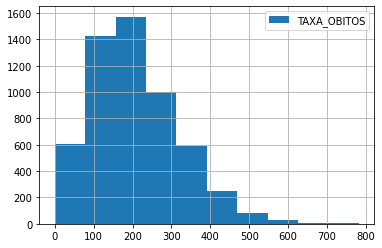

In [189]:
df_base.TAXA_OBITOS.hist(legend=True)

<AxesSubplot:>

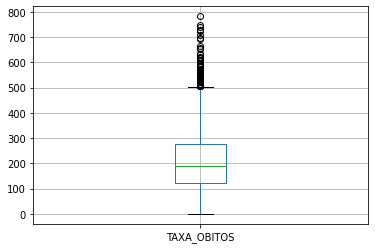

In [190]:
df_base.boxplot(column=["TAXA_OBITOS"])

In [191]:
taxa_obitos_brasil = df_base.OBITOS.sum() / df_base.POPULACAO_ESTIMADA.sum() * 100000
print('Taxa de óbitos no Brasil: '+ str(taxa_obitos_brasil))

Taxa de óbitos no Brasil: 271.0110833065168


array([[<AxesSubplot:title={'center':'Centro-Oeste'}>,
        <AxesSubplot:title={'center':'Nordeste'}>],
       [<AxesSubplot:title={'center':'Norte'}>,
        <AxesSubplot:title={'center':'Sudeste'}>],
       [<AxesSubplot:title={'center':'Sul'}>, <AxesSubplot:>]],
      dtype=object)

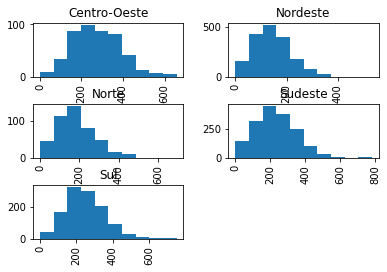

In [192]:
df_base.TAXA_OBITOS.hist(by=df_base.REGIAO)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[REGIAO]'>

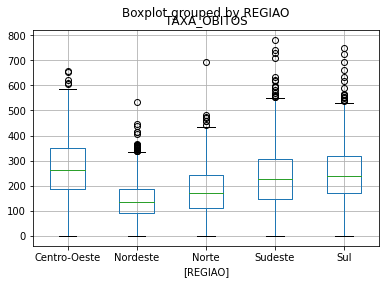

In [193]:
df_base[["TAXA_OBITOS",'REGIAO']].boxplot(by='REGIAO')

array([[<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>],
       [<AxesSubplot:title={'center':'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA'}, xlabel='[REGIAO]'>,
        <AxesSubplot:>]], dtype=object)

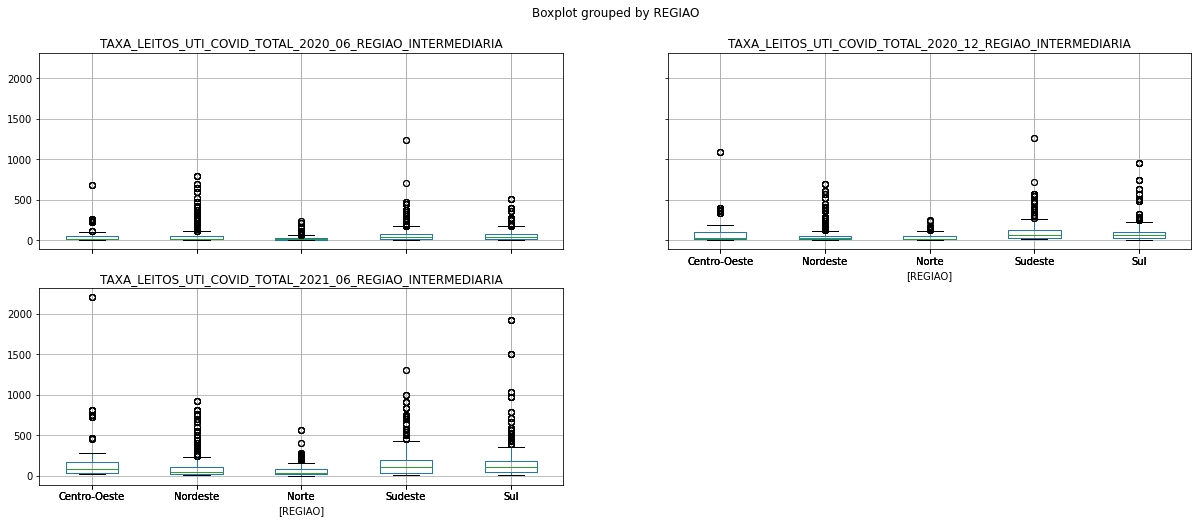

In [194]:
df_base[["TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA",
         "TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA", 'REGIAO']].boxplot(by='REGIAO', figsize=(20,8))

In [195]:
df_regioes_brasil = df_base.groupby('REGIAO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_regioes_brasil['TAXA_OBITOS'] = df_regioes_brasil.OBITOS / df_regioes_brasil.POPULACAO_ESTIMADA * 100000
print(df_regioes_brasil)

              OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
REGIAO                                               
Centro-Oeste   53883            16297074   330.629903
Nordeste      113969            57071654   199.694580
Norte          45644            18430980   247.648253
Sudeste       267433            88371433   302.623813
Sul            88593            29975984   295.546595


/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([[<AxesSubplot:title={'center':'Acre'}>,
        <AxesSubplot:title={'center':'Alagoas'}>,
        <AxesSubplot:title={'center':'Amapá'}>,
        <AxesSubplot:title={'center':'Amazonas'}>,
        <AxesSubplot:title={'center':'Bahia'}>],
       [<AxesSubplot:title={'center':'Ceará'}>,
        <AxesSubplot:title={'center':'Distrito Federal'}>,
        <AxesSubplot:title={'center':'Espírito Santo'}>,
        <AxesSubplot:title={'center':'Goiás'}>,
        <AxesSubplot:title={'center':'Maranhão'}>],
       [<AxesSubplot:title={'center':'Mato Grosso'}>,
        <AxesSubplot:title={'center':'Mato Grosso do Sul'}>,
        <AxesSubplot:title={'center':'Minas Gerais'}>,
        <AxesSubplot:title={'center':'Paraná'}>,
        <AxesSubplot:title={'center':'Paraíba'}>],
       [<AxesSubplot:title={'center':'Pará'}>,
        <AxesSubplot:title={'center':'Pernambuco'}>,
        <AxesSubplot:title={'center':'Piauí'}>,
        <AxesSubplot:title={'center':'Rio Grande do Norte'}>,
        <Ax

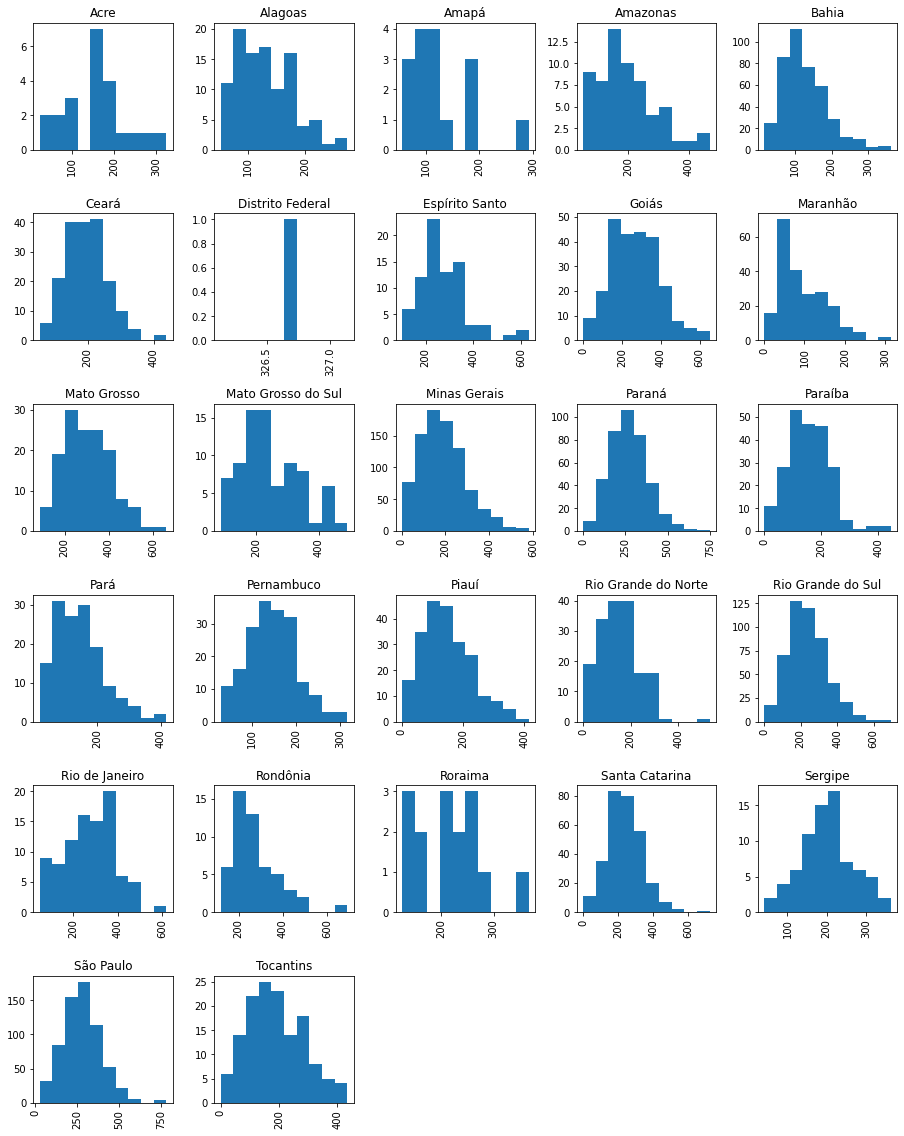

In [196]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_base.TAXA_OBITOS.hist(by=df_base.ESTADO, ax=ax)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[SIGLA_ESTADO]'>

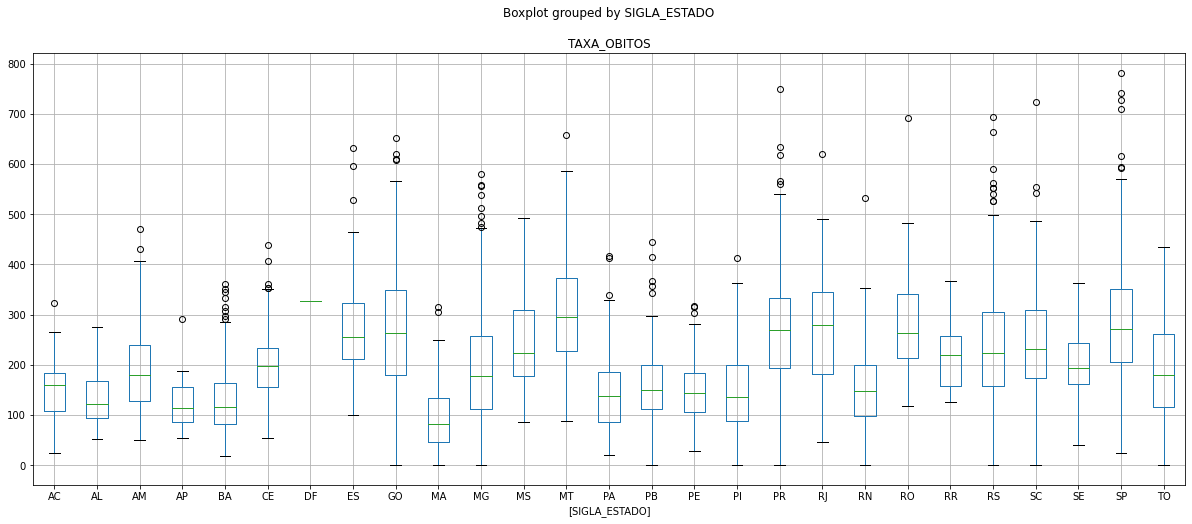

In [197]:
df_base[["TAXA_OBITOS",'SIGLA_ESTADO']].boxplot(by='SIGLA_ESTADO', figsize=(20,8))

In [198]:
df_estados_brasil = df_base.groupby('ESTADO').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_estados_brasil['TAXA_OBITOS'] = df_estados_brasil.OBITOS / df_estados_brasil.POPULACAO_ESTIMADA * 100000
print(df_estados_brasil)

                     OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
ESTADO                                                      
Acre                   1808              881935   205.003770
Alagoas                5974             3337357   179.003924
Amapá                  1941              845731   229.505599
Amazonas              13639             4144597   329.079040
Bahia                 25894            14873064   174.099970
Ceará                 23859             9132078   261.265837
Distrito Federal       9849             3015268   326.637632
Espírito Santo        11873             4018650   295.447476
Goiás                 21843             7018354   311.226820
Maranhão               9859             7075181   139.346258
Mato Grosso           12991             3484466   372.826137
Mato Grosso do Sul     9200             2778986   331.056004
Minas Gerais          51654            21168791   244.010156
Paraná                36381            11433957   318.183810
Paraíba                9

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([[<AxesSubplot:title={'center':'Barbacena'}>,
        <AxesSubplot:title={'center':'Belo Horizonte'}>,
        <AxesSubplot:title={'center':'Divinópolis'}>,
        <AxesSubplot:title={'center':'Governador Valadares'}>],
       [<AxesSubplot:title={'center':'Ipatinga'}>,
        <AxesSubplot:title={'center':'Juíz de Fora'}>,
        <AxesSubplot:title={'center':'Montes Claros'}>,
        <AxesSubplot:title={'center':'Patos de Minas'}>],
       [<AxesSubplot:title={'center':'Pouso Alegre'}>,
        <AxesSubplot:title={'center':'Teófilo Otoni'}>,
        <AxesSubplot:title={'center':'Uberaba'}>,
        <AxesSubplot:title={'center':'Uberlândia'}>],
       [<AxesSubplot:title={'center':'Varginha'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

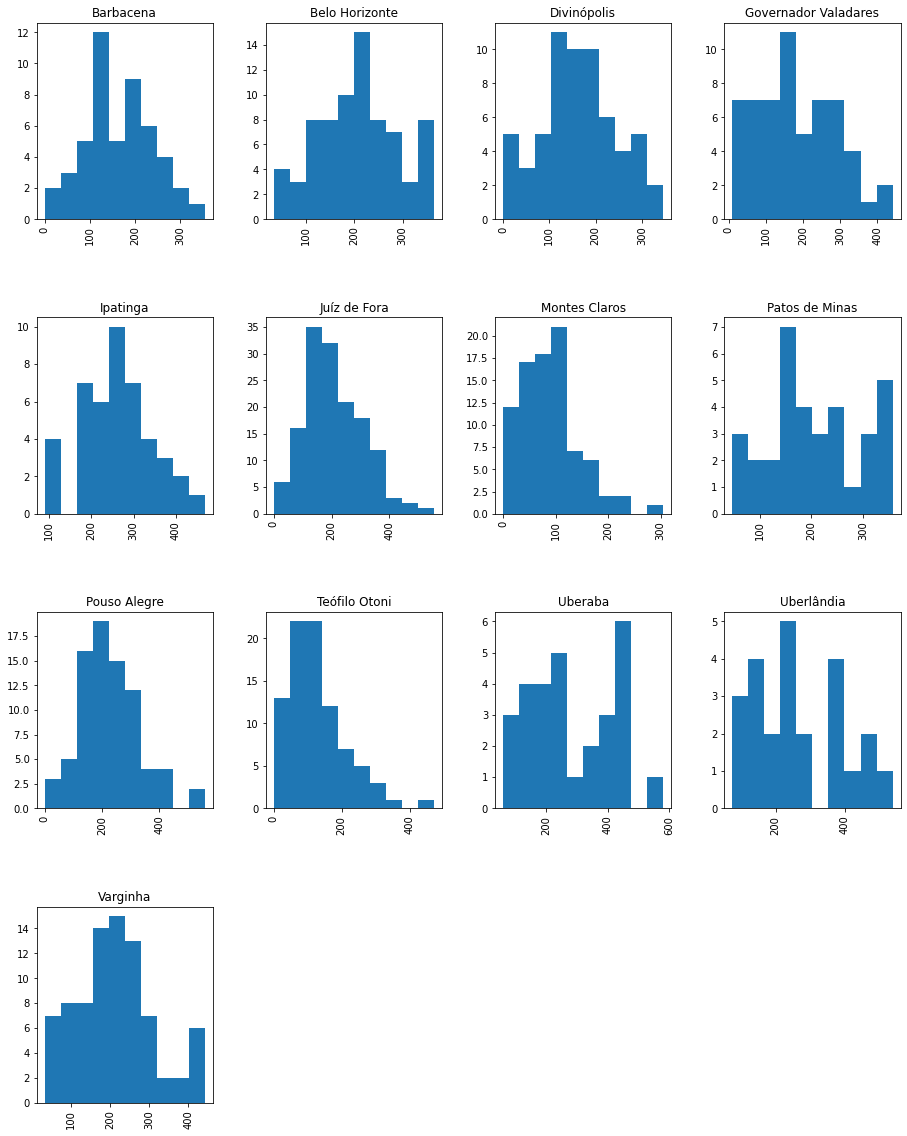

In [199]:
df_mg = df_base[df_base.SIGLA_ESTADO == 'MG']
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_mg.TAXA_OBITOS.hist(by=df_mg.REGIAO_INTERMEDIARIA, ax=ax)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[REGIAO_INTERMEDIARIA]'>

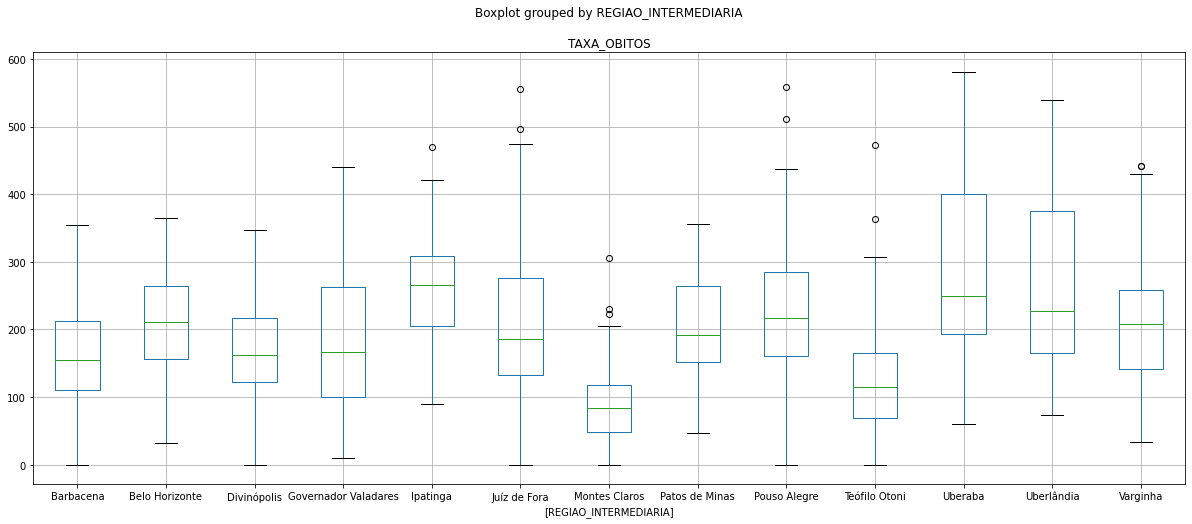

In [200]:
df_mg[["TAXA_OBITOS",'REGIAO_INTERMEDIARIA']].boxplot(by='REGIAO_INTERMEDIARIA', figsize=(20,8))

In [201]:
df_mg_regiao_intermediaria = df_mg.groupby('REGIAO_INTERMEDIARIA').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_mg_regiao_intermediaria['TAXA_OBITOS'] = df_mg_regiao_intermediaria.OBITOS / df_mg_regiao_intermediaria.POPULACAO_ESTIMADA * 100000
print(df_mg_regiao_intermediaria)

                      OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
REGIAO_INTERMEDIARIA                                         
Barbacena               1512              776567   194.703097
Belo Horizonte         15433             6284542   245.570799
Divinópolis             2930             1311962   223.329639
Governador Valadares    2091              772858   270.554229
Ipatinga                3020             1027593   293.890675
Juíz de Fora            5974             2345109   254.742957
Montes Claros           2294             1681525   136.423782
Patos de Minas          2160              824504   261.975685
Pouso Alegre            3408             1297486   262.661794
Teófilo Otoni           1703             1223321   139.211213
Uberaba                 2715              809101   335.557613
Uberlândia              4502             1171685   384.232964
Varginha                3912             1642538   238.168006


/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([[<AxesSubplot:title={'center':'Espinosa'}>,
        <AxesSubplot:title={'center':'Janaúba'}>,
        <AxesSubplot:title={'center':'Januária'}>],
       [<AxesSubplot:title={'center':'Montes Claros'}>,
        <AxesSubplot:title={'center':'Pirapora'}>,
        <AxesSubplot:title={'center':'Salinas'}>],
       [<AxesSubplot:title={'center':'São Francisco'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

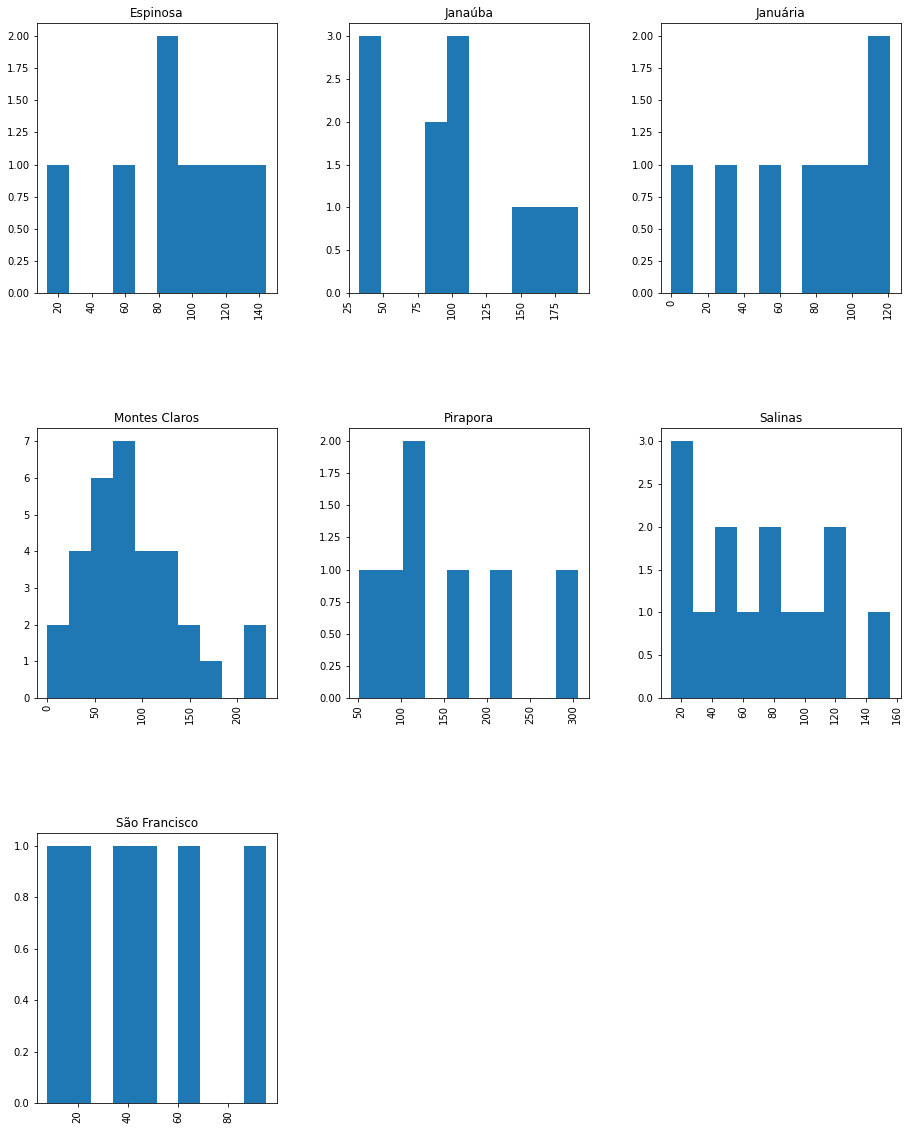

In [202]:
df_regiao_moc = df_base[df_base.REGIAO_INTERMEDIARIA == 'Montes Claros']
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_regiao_moc.TAXA_OBITOS.hist(by=df_regiao_moc.REGIAO_IMEDIATA, ax=ax)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[REGIAO_IMEDIATA]'>

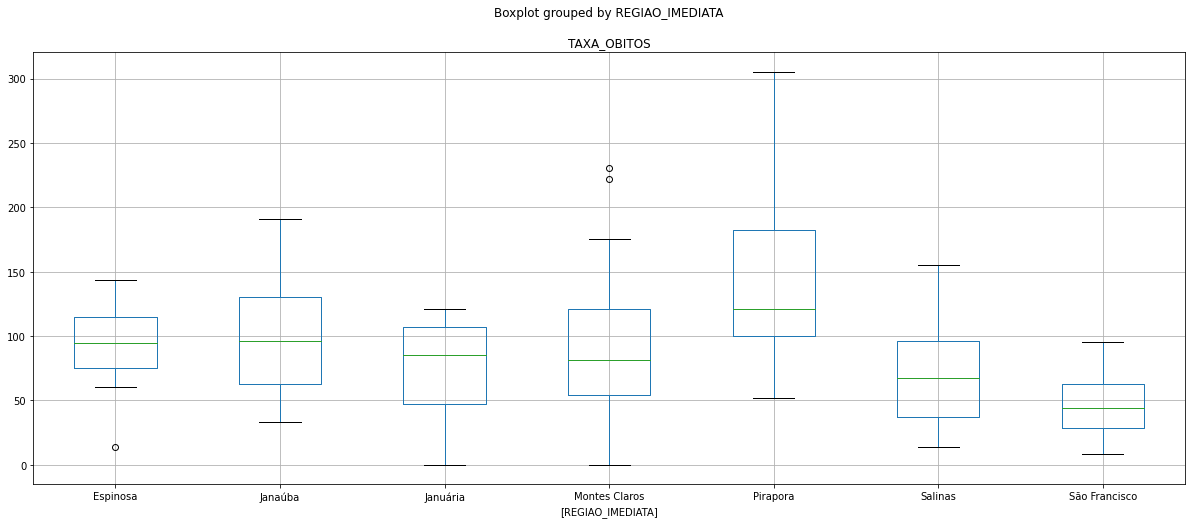

In [203]:
df_regiao_moc[["TAXA_OBITOS",'REGIAO_IMEDIATA']].boxplot(by='REGIAO_IMEDIATA', figsize=(20,8))

In [204]:
df_regiao_moc_regioes_imediatas = df_regiao_moc.groupby('REGIAO_IMEDIATA').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_regiao_moc_regioes_imediatas['TAXA_OBITOS'] = df_regiao_moc_regioes_imediatas.OBITOS / df_regiao_moc_regioes_imediatas.POPULACAO_ESTIMADA * 100000
print(df_regiao_moc_regioes_imediatas)


                 OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
REGIAO_IMEDIATA                                         
Espinosa            104               97094   107.112695
Janaúba             317              220121   144.011703
Januária            136              150489    90.372054
Montes Claros      1283              759969   168.822676
Pirapora            235              146991   159.873734
Salinas             155              192491    80.523245
São Francisco        64              114370    55.958730


In [205]:
df_regiao_januaria = df_base[df_base.REGIAO_IMEDIATA == 'Januária'][['MUNICIPIO','OBITOS','POPULACAO_ESTIMADA','TAXA_OBITOS']]
print(df_regiao_januaria)

                    MUNICIPIO  OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
2331          Bonito de Minas       0               11230     0.000000
2439           Cônego Marinho       2                7642    26.171159
2608               Itacarambi      16               18153    88.139701
2642                 Januária      77               67742   113.666558
2666                Juvenília       6                5724   104.821803
2736              Montalvânia      18               14877   120.992136
2817  Pedras de Maria da Cruz      10               12107    82.596845
2972     São João das Missões       7               13014    53.788228


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/helder/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/helder/.local/lib/python3.8/site-packages/matplotlib/ticker.py:652: UserWarning: Warning: converting a masked element to nan.
  s = self.format % xp


Text(0, 0.5, 'Taxa óbitos')

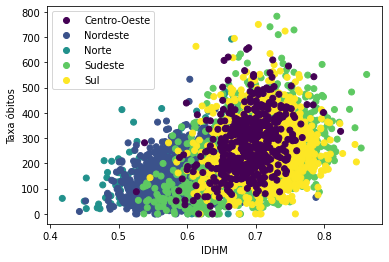

In [206]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.IDHM, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('IDHM')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

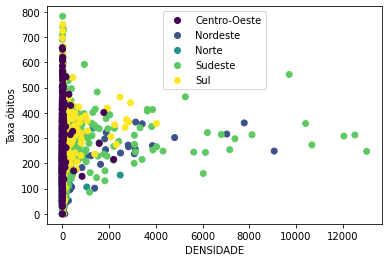

In [207]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.DENSIDADE, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('DENSIDADE')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

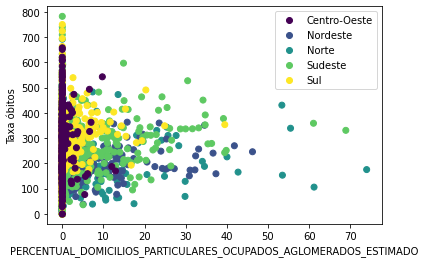

In [208]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

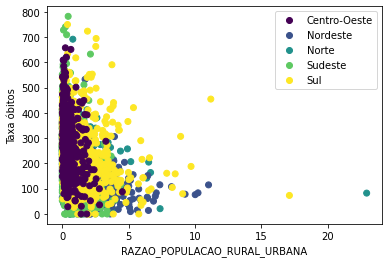

In [209]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.RAZAO_POPULACAO_RURAL_URBANA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('RAZAO_POPULACAO_RURAL_URBANA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

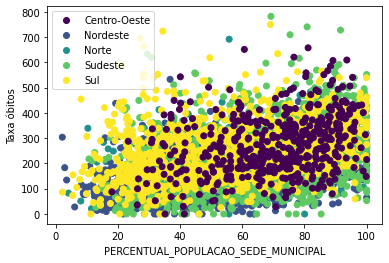

In [210]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_SEDE_MUNICIPAL, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_SEDE_MUNICIPAL')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

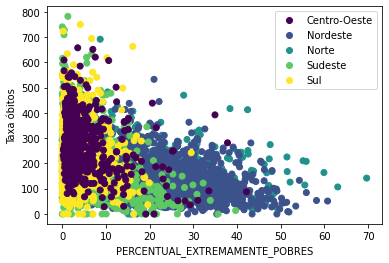

In [211]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_EXTREMAMENTE_POBRES, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_EXTREMAMENTE_POBRES')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

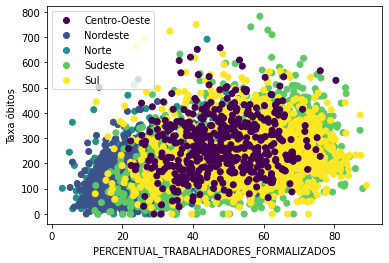

In [212]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_TRABALHADORES_FORMALIZADOS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_TRABALHADORES_FORMALIZADOS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

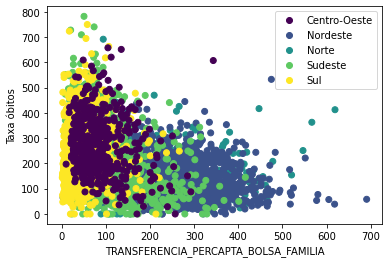

In [213]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

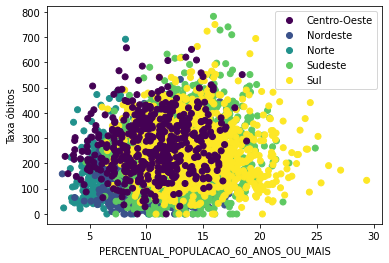

In [214]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

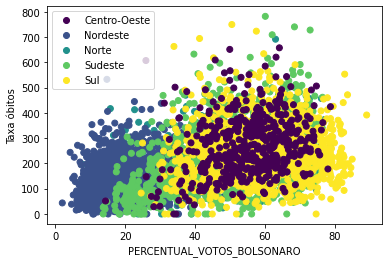

In [215]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_VOTOS_BOLSONARO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_VOTOS_BOLSONARO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

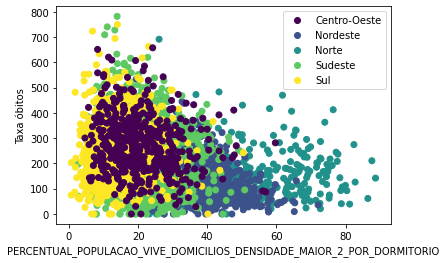

In [216]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

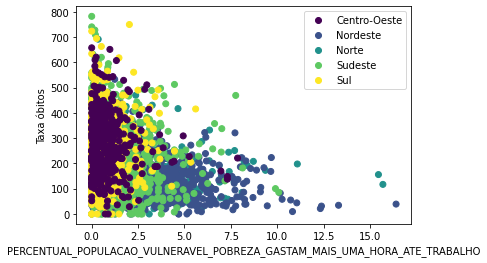

In [217]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

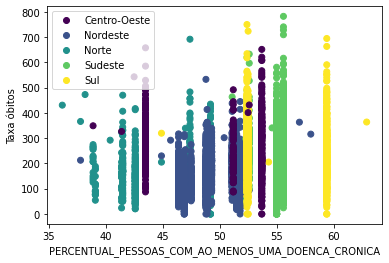

In [218]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

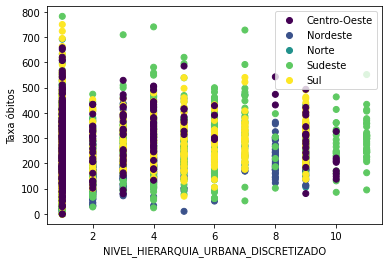

In [219]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('NIVEL_HIERARQUIA_URBANA_DISCRETIZADO')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

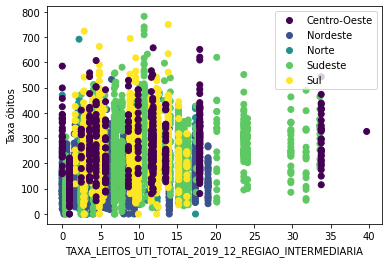

In [220]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

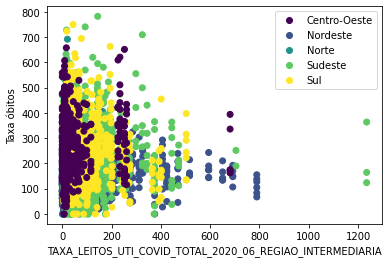

In [221]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

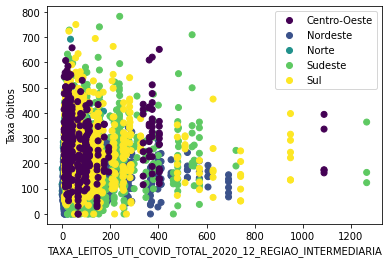

In [222]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

Text(0, 0.5, 'Taxa óbitos')

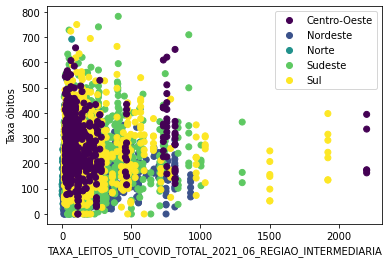

In [223]:
labels, index = np.unique(df_base.REGIAO, return_inverse=True)
grafico = plt.scatter(x=df_base.TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA, y=df_base.TAXA_OBITOS, c=index)
plt.legend(grafico.legend_elements()[0], labels)
plt.xlabel('TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA')
plt.ylabel('Taxa óbitos')

/home/helder/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/hist.py:345: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axes = _grouped_hist(


array([[<AxesSubplot:title={'center':'Capital Regional A'}>,
        <AxesSubplot:title={'center':'Capital Regional B'}>,
        <AxesSubplot:title={'center':'Capital Regional C'}>],
       [<AxesSubplot:title={'center':'Centro Local'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional A'}>,
        <AxesSubplot:title={'center':'Centro Sub-Regional B'}>],
       [<AxesSubplot:title={'center':'Centro de Zona A'}>,
        <AxesSubplot:title={'center':'Centro de Zona B'}>,
        <AxesSubplot:title={'center':'Grande Metrópole Nacional'}>],
       [<AxesSubplot:title={'center':'Metrópole'}>,
        <AxesSubplot:title={'center':'Metrópole Nacional'}>,
        <AxesSubplot:>]], dtype=object)

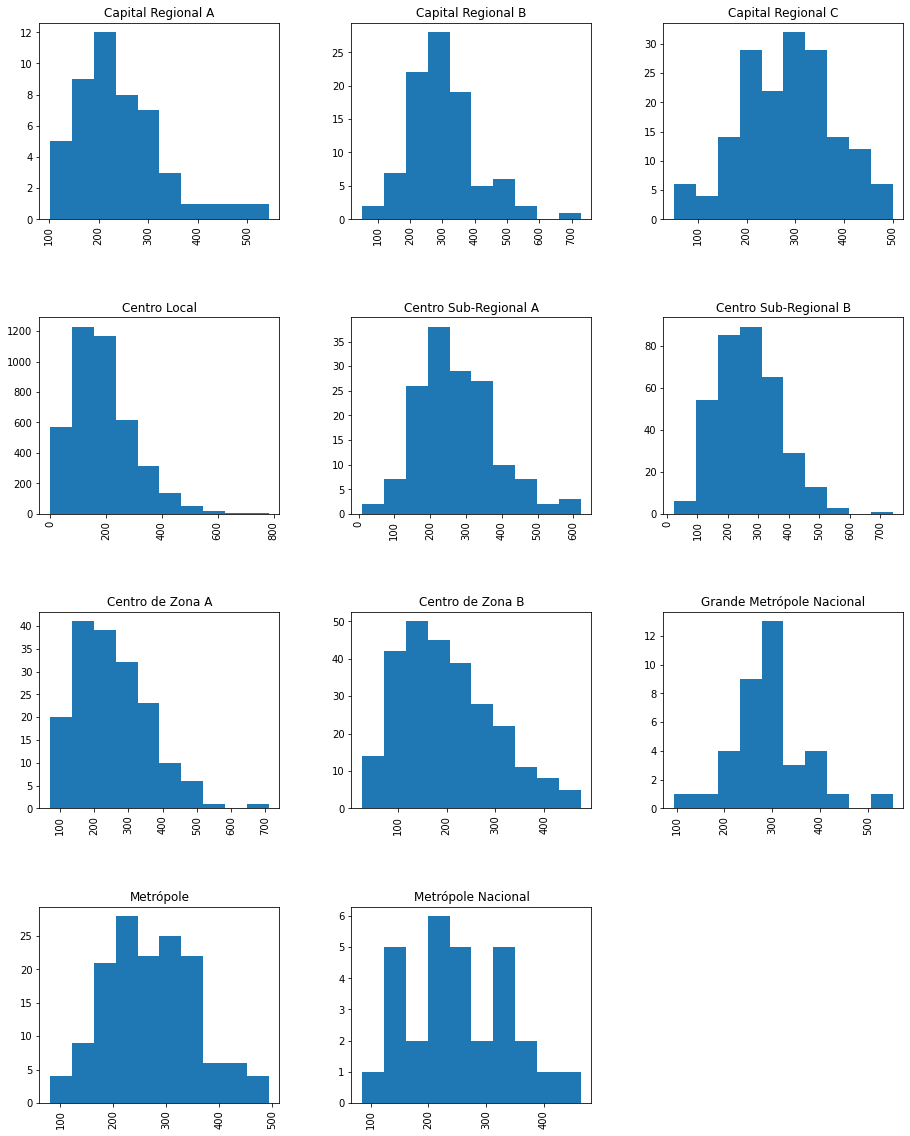

In [224]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_base.TAXA_OBITOS.hist(by=df_base.HIERARQUIA_URBANA, ax=ax)

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[HIERARQUIA_URBANA]'>

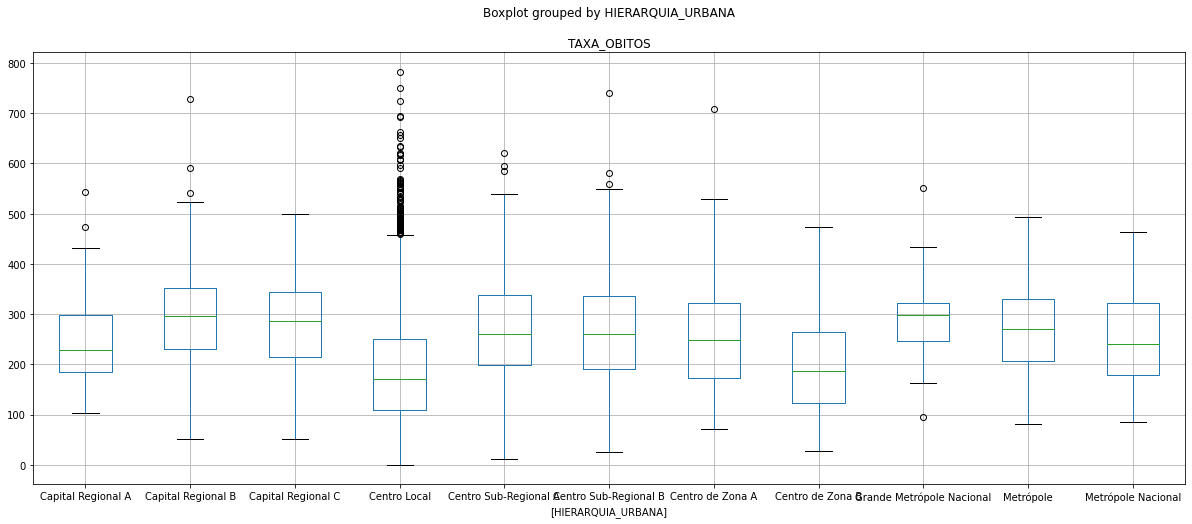

In [225]:
df_base[["TAXA_OBITOS",'HIERARQUIA_URBANA']].boxplot(by='HIERARQUIA_URBANA', figsize=(20,8))

<AxesSubplot:title={'center':'TAXA_OBITOS'}, xlabel='[NIVEL_HIERARQUIA_URBANA_DISCRETIZADO]'>

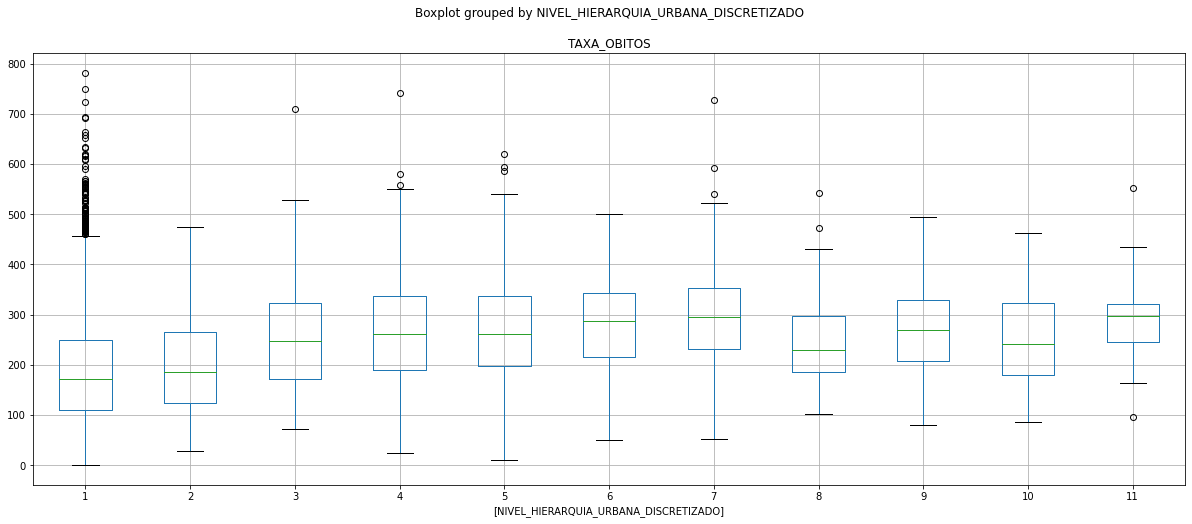

In [226]:
df_base[["TAXA_OBITOS",'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO']].boxplot(by='NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', figsize=(20,8))

In [227]:
df_base[df_base.NIVEL_HIERARQUIA_URBANA_DISCRETIZADO >= 4].sum().POPULACAO_ESTIMADA / df_base.sum().POPULACAO_ESTIMADA * 100

69.86338690096284

In [228]:
df_base.groupby('HIERARQUIA_URBANA').count().POPULACAO_ESTIMADA

HIERARQUIA_URBANA
Capital Regional A             48
Capital Regional B             92
Capital Regional C            168
Centro Local                 4115
Centro Sub-Regional A         151
Centro Sub-Regional B         345
Centro de Zona A              173
Centro de Zona B              264
Grande Metrópole Nacional      37
Metrópole                     147
Metrópole Nacional             30
Name: POPULACAO_ESTIMADA, dtype: int64

In [229]:
df_hierarquia_urbana_brasil = df_base.groupby('HIERARQUIA_URBANA').sum()[['OBITOS','POPULACAO_ESTIMADA']]
df_hierarquia_urbana_brasil['TAXA_OBITOS'] = df_hierarquia_urbana_brasil.OBITOS / df_hierarquia_urbana_brasil.POPULACAO_ESTIMADA * 100000
print(df_hierarquia_urbana_brasil)

                           OBITOS  POPULACAO_ESTIMADA  TAXA_OBITOS
HIERARQUIA_URBANA                                                 
Capital Regional A          31596             9918266   318.563749
Capital Regional B          39534            12955894   305.142972
Capital Regional C          60421            19542042   309.184680
Centro Local                92698            51038490   181.623712
Centro Sub-Regional A       32670            11555268   282.728189
Centro Sub-Regional B       49136            18260630   269.081625
Centro de Zona A            15014             6150831   244.097098
Centro de Zona B            11864             6141905   193.164824
Grande Metrópole Nacional   67091            21673440   309.553998
Metrópole                  111637            36142341   308.881486
Metrópole Nacional          57861            16768018   345.067616


In [230]:
df_hierarquia_urbana_brasil_mean = df_base.groupby('HIERARQUIA_URBANA').mean()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_mean.columns = ['TAXA_OBITOS_MEDIA']
df_hierarquia_urbana_brasil_std = df_base.groupby('HIERARQUIA_URBANA').std()[['TAXA_OBITOS']]
df_hierarquia_urbana_brasil_std.columns = ['TAXA_OBITOS_DESVIO_PADRAO']
df_hierarquia_urbana_brasil = pd.merge(df_hierarquia_urbana_brasil_mean, df_hierarquia_urbana_brasil_std, left_index=True, right_index=True)
print(df_hierarquia_urbana_brasil)

                           TAXA_OBITOS_MEDIA  TAXA_OBITOS_DESVIO_PADRAO
HIERARQUIA_URBANA                                                      
Capital Regional A                246.586650                  90.016821
Capital Regional B                304.597776                 105.665804
Capital Regional C                282.395222                  94.791949
Centro Local                      189.227399                 109.314497
Centro Sub-Regional A             272.797287                 108.388198
Centro Sub-Regional B             268.670968                 106.138583
Centro de Zona A                  252.918736                 106.581659
Centro de Zona B                  201.426013                  96.871084
Grande Metrópole Nacional         296.337538                  80.792886
Metrópole                         272.339099                  84.304371
Metrópole Nacional                250.588465                  88.746599


In [231]:
# df_base = df_base_general

In [232]:
df = df_base[
    [ 'NIVEL_HIERARQUIA_URBANA_DISCRETIZADO', 'REGIAO_METROPOLITANA', 'CAPITAL', 'POPULACAO_ESTIMADA',
      'PERCENTUAL_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS_ESTIMADO', 'PERCENTUAL_POPULACAO_0_A_5_ANOS',
      'PERCENTUAL_POPULACAO_6_A_14_ANOS', 'PERCENTUAL_POPULACAO_15_A_24_ANOS', 'PERCENTUAL_POPULACAO_25_A_39_ANOS',
      'PERCENTUAL_POPULACAO_40_A_59_ANOS', 'PERCENTUAL_POPULACAO_60_ANOS_OU_MAIS', 'DENSIDADE',
      'DENSIDADE_DEMOGRAFICA_AGLOMERADOS', 'DENSIDADE_DOMICILIOS_AGLOMERADOS','TAXA_FECUNDIDADE',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_BANHEIRO_AGUA',
      'PERCENTUAL_POPULACAO_VIVE_DOMICILIOS_DENSIDADE_MAIOR_2_POR_DORMITORIO','RAZAO_POPULACAO_MASCULINA_FEMININA',
     'RAZAO_POPULACAO_RURAL_URBANA', 'PERCENTUAL_POPULACAO_URBANA', 'PERCENTUAL_POPULACAO_SEDE_MUNICIPAL',
     'DENSIDADE_DOMICILIOS', 'PERCENTUAL_DOMICILIOS_AGLOMERADOS', 'PERCENTUAL_POPULACAO_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_ESTIMADA', 'IDHM', 'IDHM_EDUCACAO', 'IDHM_LONGEVIDADE', 'IDHM_RENDA', 'GINI',
     'PERCENTUAL_EXTREMAMENTE_POBRES', 'PERCENTUAL_POBRES',
     'PERCENTUAL_VULNERAVEIS_POBREZA', 'RAZAO_10_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES',
     'RAZAO_20_PORCENTO_MAIS_RICOS_POR_40_PORCENTO_MAIS_POBRES', 'RENDA_PER_CAPTA_MEDIA_EXTREMAMENTE_POBRES',
     'RENDA_PER_CAPTA_MEDIA_POBRES', 'RENDA_PER_CAPTA_MEDIA_VULNERAVEIS_POBREZA', 'THEIL', 'RAZAO_DEPENDENCIA',
     'TRANSFERENCIA_PERCAPTA_BOLSA_FAMILIA', 'PERCENTUAL_TRABALHADORES_CONTA_PROPRIA', 'PERCENTUAL_OCUPADOS_AGROPECUARIA', 'PERCENTUAL_OCUPADOS_COMERCIO',
     'PERCENTUAL_OCUPADOS_CONSTRUCAO', 'PERCENTUAL_OCUPADOS_MINERACAO', 'PERCENTUAL_OCUPADOS_SERVICO',
     'PERCENTUAL_OCUPADOS_SERVICOS_INDUSTRIAIS_UTILIDADE_PUBLICA', 'PERCENTUAL_OCUPADOS_INDUSTRIA',
     'PERCENTUAL_TRABALHADORES_FORMALIZADOS', 'PERCENTUAL_OCUPADOS_SEM_RENDA', 'TAXA_ATIVIDADE', 'TAXA_DESOCUPACAO',
     'PERCENTUAL_TRABALHADORES_PUBLICOS', 'PERCENTUAL_POPULACAO_VULNERAVEL_POBREZA_GASTAM_MAIS_UMA_HORA_ATE_TRABALHO',
     'PERCENTUAL_INTERNACAOES_DOENCAS_SANEAMENTO_INADEQUADO', 'PERCENTUAL_POPULACAO_COBERTA_PLANO_SAUDE',
     'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA', 'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE', 'PERCENTUAL_AVC', 'PERCENTUAL_COLESTEROL_ALTO',
     'PERCENTUAL_DOENCA_CORACAO', 'PERCENTUAL_PESSOAS_COM_AO_MENOS_UMA_DOENCA_CRONICA', 'PERCENTUAL_HIPERTENSAO',
     'PERCENTUAL_AUTO_AVALIACAO_POSITIVA_SAUDE', 'PERCENTUAL_ASMA', 'PERCENTUAL_CANCER',
     'PERCENTUAL_INSUFICIENCIA_RENAL_CRONICA', 'PERCENTUAL_DIABETES',  'TAXA_LEITOS_INTERNACAO_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2020_06_REGIAO_INTERMEDIARIA',  'TAXA_LEITOS_INTERNACAO_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_INTERNACAO_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_MEDICOS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_MEDICOS_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'TAXA_ENFERMEIROS_TOTAL_2019_12_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_ENFERMEIROS_TOTAL_2020_12_REGIAO_INTERMEDIARIA',
       'TAXA_ENFERMEIROS_TOTAL_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_REPIRADORES_EM_USO_2019_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_REPIRADORES_EM_USO_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_REPIRADORES_EM_USO_2020_12_REGIAO_INTERMEDIARIA',
      'TAXA_VENTILADORES_REPIRADORES_EM_USO_2021_06_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2020_06_REGIAO_INTERMEDIARIA',
      'TAXA_LEITOS_UTI_COVID_TOTAL_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_LEITOS_UTI_COVID_TOTAL_2021_06_REGIAO_INTERMEDIARIA',
      'PERCENTUAL_VOTOS_BOLSONARO', 'PERCENTUAL_VOTOS_HADDAD', 'TAXA_CASOS', 'TAXA_LETALIDADE', 'TAXA_OBITOS']]

df_base_general = df_base
df_null = df.isnull().any(axis=1)
df_base = df_base[df_null == False]
df = df[df_null == False]



KeyError: "['TAXA_VENTILADORES_REPIRADORES_EM_USO_2020_06_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_REPIRADORES_EM_USO_2020_12_REGIAO_INTERMEDIARIA', 'TAXA_VENTILADORES_REPIRADORES_EM_USO_2021_06_REGIAO_INTERMEDIARIA'] not in index"

In [ ]:
df_correlation = df.corr(method="spearman")

df_correlation_pvalue = pd.DataFrame(columns=['correlation_pearson', 'pvalue_pearson', 'correlation_spearman', 'pvalue_spearman'])
for column in df:
    if pd.api.types.is_numeric_dtype(df_base[column]) and column != 'TAXA_OBITOS':
        correlation_pearson, pvalue_pearson = stats.pearsonr(df.TAXA_OBITOS, df_base[column])
        correlation_spearman, pvalue_spearman = stats.spearmanr(df.TAXA_OBITOS, df_base[column])
        df_correlation_pvalue.loc[column] = [round(correlation_pearson, 4), round(pvalue_pearson, 4),
                                             round(correlation_spearman, 4), round(pvalue_spearman, 4)]
print(df_correlation_pvalue)

#### Removing outliers

In [ ]:
PAREI AQUI
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out




#### Drop missing values, normalizing data, and selecting attributes

In [ ]:
df_base = df_base.dropna()

df_antecedents_not_normalized = df_base[['POPULACAO_ESTIMADA', 'IDHM', 'IDHM_E', 'IDHM_L',
                                         'IDHM_R', 'PINTERDRSAI', 'REN_RENSF_D', 'REN_TRPCBF_D', 'REN_PVAADM',
                                         'REN_PVAAGR', 'REN_PVAIND', 'REN_PVASERV', 'TXCOBPLP', 'REGIAO_METROPOLITANA', 'FECTOT',
                                         'CORTE1','CORTE2', 'CORTE3','CORTE4','CORTE9','GINI', 'PIND', 'PMPOB', 'PPOB',
                                         'PREN10RICOS', 'PREN20','PREN20RICOS', 'PREN40','PREN60','PREN80', 'PRENTRAB',
                                         'R1040','R2040', 'RDPC1','RDPC10','RDPC2','RDPC3','RDPC4', 'RDPC5',
                                         'RIND','RMPOB','RPOB','THEIL', 'CPR','P_AGRO','P_COM','P_CONSTR','P_EXTR',
                    'P_FORMAL', 'P_SERV', 'P_TRANSF', 'REN0','REN1','REN2','REN3','REN5', 'T_ATIV', 'T_DES',
                    'THEILTRAB', 'TRABCC','TRABPUB','TRABSC', 'T_AGUA','T_BANAGUA', 'T_DENS', 'T_LUZ','AGUA_ESGOTO',
                    'T_OCUPDESLOC_1', 'PEA', 'RAZAO_HOMEM_MULHER',
                                         'RAZAO_POPULACAO_RURAL_URBANA', 'PERCENTUAL_POPULACAO_17_OU_MENOS_ANOS',
                                         'PERCENTUAL_POPULACAO_18_ATE_39_ANOS', 'PERCENTUAL_POPULACAO_40_ATE_59_ANOS',
                                         'PERCENTUAL_POPULACAO_60_OU_MAIS_ANOS', 'RAZDEP',
                                         'PERCENTUAL_POPULACAO_SEDE_MUNICIPAL', 'DENSIDADE', 'DENSIDADE_DOMICILIOS',
                                         'PERCENTUAL_DOMICILIOS_AGLOMERADOS', 'PERCENTUAL_POPULACAO_AGLOMERADOS',
                                         'DENSIDADE_DOMICILIOS_ESTIMADA', 'PER_AGSN', 'PERCENTUAL_VOTOS_BOLSONARO',
                                         'PERCENTUAL_VOTOS_HADDAD', 'CAPITAL',
                                         'PERCENTUAL_COBERTURA_ESTRATEGIA_SAUDE_FAMILIA',
                                         'PERCENTUAL_COBERTURA_AGENTES_COMUNITARIOS_SAUDE',
                                         'TAXA_LEITOS_INTERNACAO_100_MIL',
                                         'TAXA_LEITOS_UTI_100_MIL',
                                         'TAXA_MEDICOS_100_MIL',
                                         'TAXA_ENFERMEIROS_100_MIL', 'TAXA_VENTILADORES_REPIRADORES_EM_USO_100_MIL']]
scaler_antecedents = preprocessing.MinMaxScaler()
antecedents_normalized = scaler_antecedents.fit_transform(df_antecedents_not_normalized.values)
df_antecedents = pd.DataFrame(antecedents_normalized, columns=df_antecedents_not_normalized.columns)

df_consequents_not_normalized = df_base[['TAXA_CASOS_100_MIL', 'TAXA_OBITOS_100_MIL', 'TAXA_LETALIDADE']]
scaler_concequents = preprocessing.MinMaxScaler()
concequents_normalized = scaler_concequents.fit_transform(df_consequents_not_normalized.values)
df_concequents = pd.DataFrame(concequents_normalized, columns=df_consequents_not_normalized.columns)

In [ ]:
df_antecedents.IDHM_R.hist(legend=True)
df_antecedents.IDHM_E.hist(legend=True)
df_antecedents.IDHM_L.hist(legend=True)
df_antecedents.POPULACAO_ESTIMADA.hist(legend=True)

In [ ]:
df_concequents.TAXA_CASOS_100_MIL.hist(legend=True)

In [ ]:
df_concequents.TAXA_OBITOS_100_MIL.hist(legend=True)

In [ ]:
df_concequents.TAXA_LETALIDADE.hist(legend=True)

#### Executing fcmenas

In [ ]:
from random import randrange


def plot_clusters(centers, u, x_not_normalized, y_not_normalized, df_not_normalized, scaler):
    cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization
    fig, ax = plt.subplots()

    for j in range(len(centers)):
        ax.plot(x_not_normalized.values[cluster_membership == j],
                y_not_normalized.values[cluster_membership == j], '.', label="Cluster " + str(j))
        ax.set_xlabel(x_not_normalized.name)
        ax.set_ylabel(y_not_normalized.name)
    ax.legend()

    centers_not_normalized = scaler.inverse_transform(centers)
    xi = df_not_normalized.columns.get_loc(x_not_normalized.name)
    yi = df_not_normalized.columns.get_loc(y_not_normalized.name)
    for pt in centers_not_normalized:
        ax.plot(pt[xi], pt[yi], 'rs')

    plt.show()


def describe_clusters(centers, u, df_not_normalized):
    cluster_membership = np.argmax(u, axis=0)
    for j in range(len(centers)):
        print("===================Cluster {0}==================".format(j))
        for column  in df_not_normalized.columns:
            print(df_not_normalized[cluster_membership == j][column].describe())
            print("\n")


def show_results(ra, centers, u, fpc, df_not_normalized, scaler, df_analysis):
    if ra is not None:
        print('RA = {0} - Subtractive Centers = {1}; FPC = {2:.2f}'.format(ra, len(centers), fpc))
    else:
        print('Centers = {0}; FPC = {1:.2f}'.format(len(centers), fpc))
    attributes = df_not_normalized.columns

    # for i in range(len(attributes) - 1):
    #     for j in range(i + 1, len(attributes)):
    #         plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]],
    #                       df_not_normalized, scaler)
    i = randrange(len(attributes))
    j = randrange(len(attributes))
    plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]], df_not_normalized,
                  scaler)

    print("Describing clusters")
    describe_clusters(centers, u, df_not_normalized)

    print("Describing results")
    describe_clusters(centers, u, df_analysis)

In [ ]:
m = 2
epsilon = 10 ** (-4)


In [ ]:
# ra_25=0.25
# centers_25, u_25, u0, d, jm, p, fpc_25 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [ ]:
# centers_25_c, u_25_c, u0, d, jm, p, fpc_25_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [ ]:
# show_results(ra_25, centers_25, u_25, fpc_25, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_25, centers_25_c, u_25_c, fpc_25_c, df_consequents_not_normalized, scaler_concequents)

In [ ]:
# ra_19=0.19
# centers_19, u_19, u0, d, jm, p, fpc_19 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [ ]:
# centers_19_c, u_19_c, u0, d, jm, p, fpc_19_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [ ]:
# show_results(ra_19, centers_19, u_19, fpc_19, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_19, centers_19_c, u_19_c, fpc_19_c, df_consequents_not_normalized, scaler_concequents)
#

In [ ]:
centers_2, u_2, u0, d, jm, p, fpc_2 = cluster.cmeans(
    df_antecedents.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
centers_2_c, u_2_c, u0, d, jm, p, fpc_2_c = cluster.cmeans(
    df_concequents.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
show_results(None, centers_2, u_2, fpc_2, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_2_c, u_2_c, fpc_2_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)

In [ ]:
centers_3, u_3, u0, d, jm, p, fpc_3 = cluster.cmeans(
    df_antecedents.values.T, c=3, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
centers_3_c, u_3_c, u0, d, jm, p, fpc_3_c = cluster.cmeans(
    df_concequents.values.T, c=3, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
show_results(None, centers_3, u_3, fpc_3, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_3_c, u_3_c, fpc_3_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)

In [ ]:
centers_4, u_4, u0, d, jm, p, fpc_4 = cluster.cmeans(
    df_antecedents.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
centers_4_c, u_4_c, u0, d, jm, p, fpc_4_c = cluster.cmeans(
    df_concequents.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

In [ ]:
show_results(None, centers_4, u_4, fpc_4, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_4_c, u_4_c, fpc_4_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)